# Stock Deep Recurrent Q-Network 
This notebook provides an implementation of a Deep Double Recurrent Q-Network which can solve Partially Observable Markov Decision Processes. This notebook applies the technique on time series.

In [1]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import csv
import itertools
%matplotlib inline
import time
from sklearn.preprocessing import MinMaxScaler
from helper import *
#from C51 import *
from StockEnv import StockEnv
import pandas as pd
from GeometricBrownianMotion import * 
from MCSAmericanOptionPricing import *
import math

seed = 1 #time.time()
random.seed(seed)
print('Seed is:' + str(seed))

/misc/home/reco/fathanab/anaconda3/envs/tfenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/misc/home/reco/fathanab/anaconda3/envs/tfenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/misc/home/reco/fathanab/anaconda3/envs/tfenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/misc/home/re

Seed is:1


### Variable settings

In [2]:
"""So = 100 #spot_price #110 #90 #100 110 #127.62 #90
strike_price = 100 #130 #100
mu = 10/100 #risk_free_rate #0.001 #5/100
sigma = 0.20 #volatility # the historical vols or implied vols
dividend_rate = 0.0 #0.0163 #dividend yield of 1.63%
num_seeds = 20000"""
risk_free_rate = 5/100
mu = risk_free_rate
sigma = 0.20
num_seeds = 60

In [3]:
save_model_freq = 10000 #5000
Normalization = False
Window_Normalization = False #True #False
test_data_ratio = 0.2 #0.3 # 0.2

architecture = 0 #3 #0 #1 #2 #3 #4 #5
nbFilters = 32 #16 #1
paddingType = 'same' #'causal' # 'valid'
huber_loss = True #False
dueling_type = 'max' #'naive'
mask_type = 'default' #'maskFirstHalf' # 'maskByWeights' 'default'
apply_dropout = True
batch_size = 64 #16 #32 #128 #60 #20 #4 #How many experience traces to use for each training step.
memory_capacity = 3000 #3000 #1000
learning_rate = 0.0025 #0.00025 #0.01 0.025 0.0025 0.0001
apply_grad_clipping = True
grad_clipping = 5 # Maybe test with bigger values, e.g. 40 or 30
optimizer_type = 'Adam' # 'GradientDescent' 'RMSProp'

Colab = False
scriptDirectory = os.getcwd() #"C:\Code_RL\2019_11_21_shuffled_GBM_version" #"C:\\Code_RL" # os.getcwd()

history_t = 15 #5 #15 #2 #15 ##
option_T = 50 #65 #50 #100 #365 #100 #200 #365 #65 #30 #15 #40 #30 ##
#build_warm_up_state_t = option_T // 3 #option_T // 2
input_size = history_t + 2
is_training = True

In [4]:
"""stock_names = ['hpq.us.txt', 'aapl.us.txt', 'goog.us.txt', 'ibm.us.txt', 'ups.us.txt',
              'jnj.us.txt', 'msft.us.txt', 'pg.us.txt', 'tsn.us.txt', 'usa.us.txt',
              'tex.us.txt', 'sam.us.txt', 'salt.us.txt', 'tlys.us.txt', 'trq.us.txt',
              'trno.us.txt', 'trk.us.txt', 'tnp.us.txt', 'tjx.us.txt', 'tpx.us.txt',
              'fb.us.txt', 'jpm.us.txt', 'v.us.txt', 'bac.us.txt',
               'ma.us.txt', 'hd.us.txt', 'tsm.us.txt', 'dis.us.txt',
               'intc.us.txt', 'vz.us.txt', 'rds-b.us.txt', 'tm.us.txt',
               'cvx.us.txt','wfc.us.txt', 'nvs.us.txt', 'ko.us.txt',
              'mrk.us.txt', 'ba.us.txt', 'pfe.us.txt', 'cmcsa.us.txt',
               'sap.us.txt', 'chl.us.txt', 'ul.us.txt', 'bud.us.txt',
               'un.us.txt','wfc.us.txt', 'mdt.us.txt', 'hsbc.us.txt',
              'mcd.us.txt', 'nke.us.txt', 'adbe.us.txt', 'crm.us.txt',
               'tot.us.txt', 'ptr.us.txt', 'cost.us.txt', 'bp.us.txt',
               'pm.us.txt', 'amgn.us.txt', 'abbv.us.txt', 'hon.us.txt']
stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_name in stock_names:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(test_data)), test_data, color='r') """

"stock_names = ['hpq.us.txt', 'aapl.us.txt', 'goog.us.txt', 'ibm.us.txt', 'ups.us.txt',\n              'jnj.us.txt', 'msft.us.txt', 'pg.us.txt', 'tsn.us.txt', 'usa.us.txt',\n              'tex.us.txt', 'sam.us.txt', 'salt.us.txt', 'tlys.us.txt', 'trq.us.txt',\n              'trno.us.txt', 'trk.us.txt', 'tnp.us.txt', 'tjx.us.txt', 'tpx.us.txt',\n              'fb.us.txt', 'jpm.us.txt', 'v.us.txt', 'bac.us.txt',\n               'ma.us.txt', 'hd.us.txt', 'tsm.us.txt', 'dis.us.txt',\n               'intc.us.txt', 'vz.us.txt', 'rds-b.us.txt', 'tm.us.txt',\n               'cvx.us.txt','wfc.us.txt', 'nvs.us.txt', 'ko.us.txt',\n              'mrk.us.txt', 'ba.us.txt', 'pfe.us.txt', 'cmcsa.us.txt',\n               'sap.us.txt', 'chl.us.txt', 'ul.us.txt', 'bud.us.txt',\n               'un.us.txt','wfc.us.txt', 'mdt.us.txt', 'hsbc.us.txt',\n              'mcd.us.txt', 'nke.us.txt', 'adbe.us.txt', 'crm.us.txt',\n               'tot.us.txt', 'ptr.us.txt', 'cost.us.txt', 'bp.us.txt',\n              

min value of data: 62.827391863260864, max value of data: 96.83725629932668
train_size: 743
test_size: 185
min value of data: 42.213648687472705, max value of data: 94.63164479418552
train_size: 743
test_size: 185
min value of data: 142.5233705828126, max value of data: 234.45301427402765
train_size: 743
test_size: 185
min value of data: 46.6379661171951, max value of data: 77.48019990185733
train_size: 743
test_size: 185
min value of data: 96.4808456716675, max value of data: 211.67981730879436
train_size: 743
test_size: 185
min value of data: 51.02500140468074, max value of data: 92.2787059436558
train_size: 743
test_size: 185
min value of data: 138.51898662530203, max value of data: 282.301419906335
train_size: 743
test_size: 185
min value of data: 85.5926833683797, max value of data: 117.87554946635143
train_size: 743
test_size: 185
min value of data: 109.32440391088113, max value of data: 206.6928851676281
train_size: 743
test_size: 185
min value of data: 149.99709175457744, max v

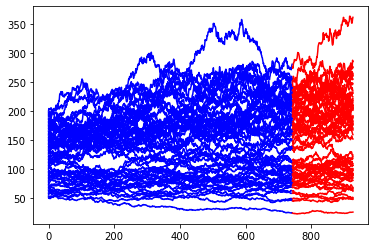

In [5]:
#Generate stocks data
stocks_data, _ = GBM(num_seeds, is_training).generate_stock_paths(mu, sigma, 928, num_seeds, is_training)
stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_data in stocks_data:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    #train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_data, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, color='r') 

### Load the game environment

Setting our environment

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 635
num_episodes_per_epoch: 40680
min value of stock: 41.83170837270812, max value of stock: 60.85618597440994


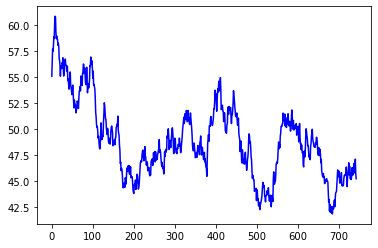

In [6]:
############################################################################
#env = StockEnv(train_data, risk_free_rate, history_t=history_t, option_T=option_T)
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
build_warm_up_state_t = env.get_build_warm_up_state()
trace_length = option_T - build_warm_up_state_t
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(train_data)) + ', max value of stock: '+str(max(train_data)))
plt.plot(range(len(train_data)), train_data, color='b')

In [7]:
num_actions = 2
num_atoms=51
vmax=float(10.)
vmin=float(-1.)
delta_z = (vmax - vmin) / float(num_atoms - 1)
_support = [vmin + i * delta_z for i in range(num_atoms)]

### Implementing the network itself

In [8]:
class Qnetwork():
    def __init__(self,myScope):
        
        self._support = tf.linspace(vmin, vmax, num_atoms)
        
        self.scalarInput = tf.placeholder(shape=[None,input_size],dtype=tf.float32)
        
        # depending on the chosen architecture, data is processed through differents layers
        
        # convolutions are used in all type, except architecture 0 which only uses LSTM
        if architecture != 0:
          self.InputConvIn = tf.reshape(self.scalarInput,shape=[-1,input_size,1], name='InputConvIn')
          self.conv1 = tf.keras.layers.Conv1D(filters=nbFilters,
                                               kernel_size=3,
                                               strides=1,
                                               padding= paddingType, #'same',
                                               activation=tf.nn.relu)(inputs=self.InputConvIn)
        
        if architecture == 0: # LSTM only
          self.scalarInputFlattened = tf.keras.layers.Flatten()(self.scalarInput)
        elif architecture == 1: # only one convolution
          self.conv1flattened = tf.reshape(self.conv1,shape=[-1,self.conv1.shape[1]*self.conv1.shape[2]], name='conv1flattened')
        elif architecture == 2: # only one convolution followed by max pooling
          self.maxPooling1D = tf.keras.layers.MaxPool1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.maxPooling1Dflattened = tf.reshape(self.maxPooling1D,shape=[-1,self.maxPooling1D.shape[1]*self.maxPooling1D.shape[2]], name='maxPooling1Dflattened')
        elif architecture == 3: # only one convolution followed by average pooling
          self.AveragePooling1D = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.AveragePooling1Dflattened = tf.reshape(self.AveragePooling1D,shape=[-1,self.AveragePooling1D.shape[1]*self.AveragePooling1D.shape[2]], name='AveragePooling1Dflattened')  
        elif architecture == 4: #VGG (one block of 2 convolutions followed by avg pooling)
          self.conv2 = tf.keras.layers.Conv1D(filters=nbFilters,
                                               kernel_size=3,
                                               strides=1,
                                               padding= paddingType, #'same',
                                               activation=tf.nn.relu)(inputs=self.conv1)
          self.AveragePooling1D4 = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv2)
          self.AveragePooling1Dflattened4 = tf.reshape(self.AveragePooling1D4,shape=[-1,self.AveragePooling1D4.shape[1]*self.AveragePooling1D4.shape[2]], name='AveragePooling1Dflattened4')
        elif architecture == 5: #Lenet (conv, avg pooling, conv, avg pooling)
          self.AveragePooling1D = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.conv2 = tf.keras.layers.Conv1D(filters=nbFilters,
                                               kernel_size=3,#5, #3, #maybe unstable calculations because of 5 instead of 3
                                               strides=1,
                                               padding= paddingType, #'same',
                                               #activation=tf.keras.activations.hard_sigmoid
                                               #activation=tf.keras.activations.sigmoid
                                               #activation=tf.keras.activations.tanh
                                               activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.AveragePooling1D5 = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv2)
          self.AveragePooling1Dflattened5 = tf.reshape(self.AveragePooling1D5,shape=[-1,self.AveragePooling1D5.shape[1]*self.AveragePooling1D5.shape[2]], name='AveragePooling1Dflattened5')
        elif architecture == 6: #Googlenet (Inception net: combine (conv&avgPooling) + conv1 + conv3 + conv5)
          self.AveragePooling1D = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.conv11 = tf.keras.layers.Conv1D(filters=5,
                                             kernel_size=1,
                                             strides=1,
                                             padding=paddingType,#'same',
                                             activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.conv3 = tf.keras.layers.Conv1D(filters=5,
                                             kernel_size=3,
                                             strides=1,
                                             padding=paddingType,#'same',
                                             activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.conv5 = tf.keras.layers.Conv1D(filters=5,
                                             kernel_size=5,
                                             strides=1,
                                             padding=paddingType,#'same',
                                             activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.filterconcatenation = tf.concat([self.conv11, self.conv3, self.conv5, self.AveragePooling1D], 2, name = 'filterconcatenation')
          self.filterconcatenationflattened = tf.reshape(self.filterconcatenation,shape=[-1,self.filterconcatenation.shape[1]*self.filterconcatenation.shape[2]], name='filterconcatenationflattened')
        
        self.trainLength = tf.placeholder(dtype=tf.int32)
        self.batch_size = tf.placeholder(dtype=tf.int32,shape=[])
 
        #We take the output from the final convolutional layer and send it to a recurrent layer.
        #The input must be reshaped into [batch x trace x units] for rnn processing, 
        #and then returned to [batch x units] when sent through the upper levles.
        if architecture == 0:
          self.convFlat = tf.reshape(self.scalarInputFlattened,[self.batch_size,self.trainLength,input_size])
        elif architecture == 1:
          self.convFlat = tf.reshape(self.conv1flattened,[self.batch_size,self.trainLength,self.conv1flattened.shape[1]])
        elif architecture == 2:
          self.convFlat = tf.reshape(self.maxPooling1Dflattened,[self.batch_size,self.trainLength,self.maxPooling1Dflattened.shape[1]])
        elif architecture == 3:
          self.convFlat = tf.reshape(self.AveragePooling1Dflattened,[self.batch_size,self.trainLength,self.AveragePooling1Dflattened.shape[1]])
        elif architecture == 4:
          self.convFlat = tf.reshape(self.AveragePooling1Dflattened4,[self.batch_size,self.trainLength,self.AveragePooling1Dflattened4.shape[1]])
        elif architecture == 5:
          self.convFlat = tf.reshape(self.AveragePooling1Dflattened5,[self.batch_size,self.trainLength,self.AveragePooling1Dflattened5.shape[1]])
        elif architecture == 6:
          self.convFlat = tf.reshape(self.filterconcatenationflattened,[self.batch_size,self.trainLength,self.filterconcatenationflattened.shape[1]])
        
        # use cudnn-based cells to leverage Nvidia GPUs
        single_cell = lambda: tf.contrib.cudnn_rnn.CudnnCompatibleLSTMCell(h_size)
    
        # NOTE: Even if there's only one layer, the cell needs to be wrapped in MultiRNNCell.
        lstm_cells = [single_cell() for _ in range(num_layers)]
        if is_training and apply_dropout and dropout < 1:
            lstm_cells = [tf.contrib.rnn.DropoutWrapper(
                lstm, input_keep_prob=1.0, output_keep_prob=1.0 - dropout, state_keep_prob=1.0 - dropout
            ) for lstm in lstm_cells]
        multi_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells, state_is_tuple=True)

        self.state_in = tf.placeholder(tf.float32, [num_layers, 2, None, h_size])
        state_per_layer_list = tf.unstack(self.state_in, axis=0)
        rnn_tuple_state = tuple(
            [tf.contrib.rnn.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
             for idx in range(num_layers)]
        )
        
        # calculate the real length of each episode (since remaining states are filled with 0s after selling)
        # This is required by RNN 
        self.seq_len = length(self.convFlat)
        
        self.rnn,self.rnn_state = tf.nn.dynamic_rnn(\
                cell=multi_cell,
                inputs=self.convFlat,                                    
                dtype=tf.float32,
                initial_state=rnn_tuple_state, 
                sequence_length=self.seq_len,
                scope=myScope+'_lstm')
        

        self.rnn = tf.reshape(self.rnn,shape=[-1,h_size])
        
        self.weights_initializer = tf.contrib.slim.variance_scaling_initializer(factor=1.0 / np.sqrt(3.0), mode='FAN_IN', uniform=True)
        self.net = tf.contrib.slim.fully_connected(
              self.rnn, #self.net,
              num_actions * num_atoms,
              activation_fn=None,
              weights_initializer=self.weights_initializer)

        self.logits = tf.reshape(self.net, [-1, num_actions, num_atoms])
        self.probabilities = tf.contrib.layers.softmax(self.logits)
        self.q_values = tf.reduce_sum(self._support * self.probabilities, axis=2)
        
        self.predict = tf.argmax(self.q_values,1)
        
            
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)    
        # create placeholder for target_distribution
        self.target_distribution = tf.placeholder(shape=[None,num_atoms],dtype=tf.float32)

        # size of indices: batch_size x 1.
        self.indices = tf.range(tf.shape(self.logits)[0])[:, None]
        # size of reshaped_actions: batch_size x 2.
        self.reshaped_actions = tf.concat([self.indices, self.actions[:, None]], 1)
        # For each element of the batch, fetch the logits for its selected action.
        self.chosen_action_logits = tf.gather_nd(self.logits,
                                            self.reshaped_actions)

        self.td_error = tf.nn.softmax_cross_entropy_with_logits(labels=self.target_distribution,logits=self.chosen_action_logits)
        # In order to only propogate accurate gradients through the network, we can mask the first
        # half of the losses for each trace as per Lample & Chaplot 2016
        # We can also use gradual weights to avoid neglecting short episodes at the beginning
        # maybe seq_len used in averaging should also change subsequently !
        if mask_type == 'maskFirstHalf':
            self.maskA = tf.zeros([self.batch_size,self.trainLength//2])
            self.maskB = tf.ones([self.batch_size,self.trainLength//2])
            self.mask = tf.concat([self.maskA,self.maskB],1)
            self.mask = tf.reshape(self.mask,[-1])
            self.td_error = self.td_error * self.mask
        elif mask_type == 'maskByWeights': 
            #self.mask_weights = tf.range(start=0, limit=1, delta=1/self.trainLength)
            self.mask_weights = tf.range(start=0.1, limit=1, delta=0.9/tf.cast(self.trainLength, tf.float32))
            self.mask = tf.tile(self.mask_weights, [self.batch_size])
            self.td_error = tf.multiply(self.td_error, tf.cast(self.mask, tf.float32))
        elif mask_type == 'default':
            self.td_error = self.td_error
        
        # divide by the real length of episodes instead of averaging which is incorrect
        self.loss = tf.cast(tf.reduce_sum(self.td_error), tf.float64) / tf.cast(tf.reduce_sum(self.seq_len), tf.float64)
        self.check_ops = tf.debugging.check_numerics( self.loss, "self.loss contain Nan or Inf", name="self.check_ops")
        
        if optimizer_type == 'Adam':
            optimizer = tf.train.AdamOptimizer(learning_rate)
        elif optimizer_type == 'GradientDescent':
            optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        elif optimizer_type == 'RMSProp':
            optimizer = tf.train.RMSPropOptimizer(learning_rate)
        
        if apply_grad_clipping:
            # calculate gradients and clip them to handle outliers
            tvars = tf.trainable_variables()
            grads, _ = tf.clip_by_global_norm(tf.gradients(self.loss, tvars), grad_clipping)
            self.updateModel = optimizer.apply_gradients(
                    zip(grads, tvars),
                    # global_step=tf.contrib.framework.get_or_create_global_step(),
                    name="updateModel")
        else:
            self.updateModel = optimizer.minimize(self.loss, name="updateModel")

### Experience Replay

These classes allow us to store experies and sample then randomly to train the network.
Episode buffer stores experiences for each individal episode.
Experience buffer stores entire episodes of experience, and sample() allows us to get training batches needed from the network.

In [9]:
class experience_buffer():
    def __init__(self, buffer_size = memory_capacity, build_warm_up_state_t=build_warm_up_state_t):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + 1 >= self.buffer_size:
            self.buffer[0:(1+len(self.buffer))-self.buffer_size] = []
        self.buffer.append(experience)
    
    def sample(self,batch_size):
        sampled_episodes = random.sample(self.buffer,batch_size)
        #sampled_episodes = np.array(sampled_episodes)
        sampled_episodes = self.processEpisodes(sampled_episodes)
        return np.reshape(sampled_episodes,[-1,5])
    
    def processEpisodes(self,sampled_episodes):
        sampledTraces = []
        for episode in sampled_episodes:
            sampledTraces.append(episode[build_warm_up_state_t:])
        sampledTraces = np.array(sampledTraces)
        return sampledTraces

### Training the network

In [10]:
#Setting the training parameters
num_layers = 3 # Number of layer of LSTM
h_size = 512 #256 #512 #128 #512 #256 #512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
keep_prob = 0.8
dropout = 1 - keep_prob  # dropout amount
update_freq = 5 #30 #10 #5 #How often to perform a training step.
update_online_freq = 5 #10 #5 #3 #5
update_target_freq = 30 #300 #30
#gamma = discount_factor #.99 #.95 #1 #Discount factor on the target Q-values
gamma = env.get_discount_factor(1) # discount for 1 day
startE = 1 #0.1 #1 #Starting chance of random action
endE = 0.1 #0.01 #0.1 #Final chance of random action
num_epochs = 5
num_episodes = env.get_total_num_episodes_per_epoch()*num_epochs #30 #50000 #20000 #100000 #20000 #3000 #20000 #30000 #10000 #4000 #100000 #40000
pre_train_episodes = int(memory_capacity * 0.1) # 0.25 300 #300 #200 #600 #200
annealing_episodes = int(num_episodes * 0.3) #4*memory_capacity #0.7*memory_capacity #400 #memory_capacity #400
pre_exploitation_episodes = int(num_episodes * 0.6)
annealing_exploitation_episodes = int(num_episodes * 0.25)
exploitationE =  0.01 #0.008 #0.02
load_model = False #Whether to load a saved model.
path = os.path.join(scriptDirectory, 'savedModel') #The path to save our model to.
max_epLength = option_T #env.get_max_episode_time() #option_T + build_warm_up_state_t
summaryLength = 100 #Number of epidoes to periodically save for analysis
summaryAverageReward = 5000
summaryEpoch = env.get_total_num_episodes_per_epoch()
tau = 0.001 # learning rate (also referred to as step size) for target network
softUpdate = False # use soft or hard updates
#trained_model_name = os.path.join(path, 'architecture' + str(architecture) + '-option_T' + str(option_T) + '-history_t' + str(history_t) + '-num_episodes' + str(num_episodes) + '-tau' + str(tau) + '-softUpdate' + str(softUpdate) + '-dropout' + str(dropout) + '-mask' + str(mask_type) + '-dueling_type' + str(dueling_type) + '-So' + str(So) + '-strike_price' + str(strike_price) + '-mu' + str(mu) + '-sigma' + str(sigma) + '-num_seeds' + str(num_seeds))
trained_model_name = os.path.join(path, 'C51_noSoft_arch' + str(architecture)\
                    + '-option_T' + str(option_T) + '-history_t' + str(history_t)\
                    + '-num_episodes' + str(num_episodes)\
                    + '-softUpdate' + str(softUpdate) + '-tau' + str(tau)\
                    + '-dropout' + str(dropout) + str(apply_dropout)\
                    + '-num_layers' + str(num_layers) #+ '-apply_dropout' + str(apply_dropout)\
                    + '-freq' + str(update_target_freq) + '-batch' + str(batch_size)\
                    + '-capacity' + str(memory_capacity) + '-lambda' + str(learning_rate))
final_trained_model_name = trained_model_name + '-final'
exploration_type = 'Random'
print('#num_episodes: ' + str(num_episodes))
print('#trace_length: ' + str(trace_length))
#print('#discount_factor: ' + str(discount_factor))
print('#gamma: ' + str(gamma))

#num_episodes: 203400
#trace_length: 38
#gamma: 0.9998016069840849


In [11]:
begin_time = time.time()
tf.reset_default_graph()
#We define the primary and target q-networks
mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=5)

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau,softUpdate)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
# amounts by which to anneal
episodeDrop = (startE - endE)/annealing_episodes

episodeDrop2 = (endE - exploitationE)/annealing_exploitation_episodes

#create lists to contain total rewards, steps per episode, sell time and epsilon
jList = []
rList = []
sTimeList = [] # sell time list
eList = []

percentage_rList = []
real_percentage_rList = []

NonRandom_percentage_rList = []
NonRandom_real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

NonRandom_option_percentage_rList = []
NonRandom_option_real_percentage_rList = []

#Non random day Lists
NonRandomrList = []
NonRandomsTimeList = [] # sell time list

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
AvgEpisodeListEpoch = []
AvgrListEpoch = []
AvgsTimeListEpoch = []

AvgLossList = []
AvgQSellLossList = []

AvgLossListEpochTemp = [] # Temp
AvgLossListEpoch = [] # permanent

AvgMainQList = []
AvgTargetQList = []
AvgMainMaxQList = []
AvgMainHoldQList = []
AvgMainSellQList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

# Non random days
AvgNonRandomrList = []
AvgNonRandomsTimeList = []

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)  

#Some config to parralelize and leverage the GPU capabilities.
config = tf.ConfigProto()
config.intra_op_parallelism_threads = 0 #16 #44
config.inter_op_parallelism_threads = 0 #16 #44
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
#config.device_count = {"CPU": 4}, # limit to num_cpu_core CPU usage 
#config.log_device_placement = True
#tf.Session(config=config)

with tf.Session(config=config) as sess, tf.device('/gpu:1'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
   
    updateTarget(targetOps,sess) #Update the target network.
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the lstm's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        
        if exploration_type == 'Random' and np.random.rand(1) < e:
            sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        else:
            sell_time = -1
            
        while j < max_epLength: 
            #Choose an action greedily (with e chance of random action) from the Q-network
            if env.is_episode_finished(): # fill with empty state till the end to have episodes of equal length to train
                a = 0 # arbitrary
                s1P,r,d = env.empty_step()
            else:
                if i < pre_train_episodes or env.get_time() < build_warm_up_state_t or sell_time != -1:    
                    #construct the state for following steps of same episode
                    if sell_time != -1:
                        state1 = np.zeros((num_layers, 2, 1, h_size))
                    else:
                        state1 = sess.run(mainQN.rnn_state,\
                            feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                    
                    if env.get_time() < build_warm_up_state_t or env.get_payoff() <= 0:
                        a = 0 #hold
                    elif sell_time != -1:
                        if j == sell_time and d == False:
                            a = 1
                        else:
                            a = 0
                    elif j == max_epLength - 1 and d == False:
                        a = 1
                    else:
                        a = np.random.randint(0,2)

                else:
                    a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                    a = a[0]
            
                s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        eList.append(e)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)
        
        if sell_time == -1:
            NonRandomrList.append(rAll)
            NonRandomsTimeList.append(env.get_sell_time() + 1)
            #NonRandom_percentage_rList.append(env.get_percentage_return())
            #NonRandom_real_percentage_rList.append(env.get_real_percentage_return())
            
            stock_percentage_return, option_percentage_return = env.get_percentage_return()
            NonRandom_percentage_rList.append(stock_percentage_return)
            NonRandom_option_percentage_rList.append(option_percentage_return)
            stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
            NonRandom_real_percentage_rList.append(stock_percentage_return)
            NonRandom_option_real_percentage_rList.append(option_percentage_return)

        if i >= pre_train_episodes:
            #Reset the lstm's hidden state
            state_train = np.zeros((num_layers, 2, batch_size, h_size))
            #Get a random batch of experiences.
            trainBatch = myBuffer.sample(batch_size)
            #Below we perform the Double-DQN update to the target Q-values
            """Q1, main_Q = sess.run([mainQN.predict, mainQN.Qout], feed_dict={\
                                mainQN.scalarInput:np.vstack(trainBatch[:,3]),\
                                mainQN.trainLength:trace_length,mainQN.state_in:state_train,mainQN.batch_size:batch_size})
            Q2 = sess.run(targetQN.Qout, feed_dict={\
                                targetQN.scalarInput:np.vstack(trainBatch[:,3]),\
                                targetQN.trainLength:trace_length,targetQN.state_in:state_train,targetQN.batch_size:batch_size})
            terminal = -(trainBatch[:,4] - 1) # done or not to add the future reward or not
            doubleQ = Q2[range(batch_size*trace_length),Q1]
            targetQ = trainBatch[:,2] + (gamma*doubleQ * terminal)
            #Update the network with our target values.
            loss,Q_sell_loss, _, _ = sess.run([mainQN.loss, mainQN.Q_sell_loss, mainQN.check_ops, mainQN.updateModel], \
                                feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ,\
                                mainQN.actions:trainBatch[:,1],mainQN.trainLength:trace_length,\
                                mainQN.state_in:state_train,mainQN.batch_size:batch_size})"""
            ######
            """num_samples = batch_size*trace_length
            # size of rewards: batch_size x 1
            rewards = trainBatch[:,2][:, None]

            # size of tiled_support: batch_size x num_atoms
            #tiled_support = tf.tile(mainQN._support, [batch_size])
            tiled_support = tf.tile(mainQN._support, [num_samples])
            #print("#1tiled_support: " + str(tiled_support.shape))
            #tiled_support = tf.reshape(tiled_support, [batch_size, num_atoms])
            tiled_support = tf.reshape(tiled_support, [num_samples, num_atoms])
            #print("#2tiled_support: " + str(tiled_support.shape))
            
            # size of target_support: batch_size x num_atoms
            #print("trainBatch[:,4]: " + str(trainBatch[:,4]))
            #is_terminal_multiplier = 1. - tf.cast(np.vstack(trainBatch[:,4]), tf.float32)
            #is_terminal_multiplier = 1. - tf.cast(np.array(trainBatch[:,4]), tf.float32)
            #is_terminal_multiplier = tf.cast(-(np.array(trainBatch[:,4]) - 1), tf.float32)
            is_terminal_multiplier = -(np.array(trainBatch[:,4]) - 1)
            # Incorporate terminal state to discount factor.
            # size of gamma_with_terminal: batch_size x 1
            gamma_with_terminal = gamma * is_terminal_multiplier
            gamma_with_terminal = gamma_with_terminal[:, None]

            target_support = rewards + gamma_with_terminal * tiled_support
            
            
            next_qt_argmax = sess.run([mainQN.predict], feed_dict={\
                                mainQN.scalarInput:np.vstack(trainBatch[:,3]),\
                                mainQN.trainLength:trace_length,mainQN.state_in:state_train,mainQN.batch_size:batch_size})
            next_qt_argmax = np.reshape(next_qt_argmax, [-1, 1])
            probabilities = sess.run(targetQN.probabilities, feed_dict={\
                                targetQN.scalarInput:np.vstack(trainBatch[:,3]),\
                                targetQN.trainLength:trace_length,targetQN.state_in:state_train,targetQN.batch_size:batch_size})
            #batch_indices = tf.range(tf.to_int64(batch_size))[:, None]
            #batch_indices = tf.range(tf.to_int64(num_samples))[:, None]
            batch_indices = np.arange(num_samples)[:, None]
            #print("#batch_indices: " + str(batch_indices.shape))
            #print("#next_qt_argmax: " + str(np.array(next_qt_argmax).shape))
            #print("#next_qt_argmax: " + str(tf.shape(next_qt_argmax)))
            # size of next_qt_argmax: batch_size x 2
            #batch_indexed_next_qt_argmax = tf.concat([batch_indices, next_qt_argmax], axis=1)
            batch_indexed_next_qt_argmax = np.concatenate([batch_indices, next_qt_argmax], axis=1)
        
            
            # size of next_probabilities: batch_size x num_atoms
            next_probabilities = tf.gather_nd(probabilities, batch_indexed_next_qt_argmax)
            

            target_distribution = project_distribution(target_support, next_probabilities, mainQN._support)
            target_distribution = target_distribution.eval()
            
            loss, _, _ = sess.run([mainQN.loss, mainQN.check_ops, mainQN.updateModel], \
                                feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.target_distribution:target_distribution,\
                                mainQN.actions:trainBatch[:,1],mainQN.trainLength:trace_length,\
                                mainQN.state_in:state_train,mainQN.batch_size:batch_size})"""
            #####################
            num_samples = batch_size*trace_length
            #np.zeros((action_size, num_samples, num_atoms))
            #m_prob = [np.zeros((num_samples, self.num_atoms)) for i in range(action_size)]
            #m_prob = np.zeros((num_samples, num_actions, num_atoms))
            m_prob = np.zeros((num_samples, num_atoms))
            """for i in range(num_samples):
                state_inputs[i,:,:,:] = replay_samples[i][0]
                action.append(replay_samples[i][1])
                reward.append(replay_samples[i][2])
                next_states[i,:,:,:] = replay_samples[i][3]
                done.append(replay_samples[i][4])"""

            #z = self.model.predict(next_states) # Return a list [32x51, 32x51, 32x51]
            #z_ = self.target_model.predict(next_states) # Return a list [32x51, 32x51, 32x51]

            # Get Optimal Actions for the next states (from distribution z)
            """optimal_action_idxs = []
            z_concat = np.vstack(z)
            q = np.sum(np.multiply(z_concat, np.array(self.z)), axis=1) # length (num_atoms x num_actions)
            q = q.reshape((num_samples, action_size), order='F')
            optimal_action_idxs = np.argmax(q, axis=1)"""
            
            optimal_action_idxs = sess.run([mainQN.predict], feed_dict={\
                                mainQN.scalarInput:np.vstack(trainBatch[:,3]),\
                                mainQN.trainLength:trace_length,mainQN.state_in:state_train,mainQN.batch_size:batch_size})
            optimal_action_idxs = np.reshape(optimal_action_idxs, [-1, 1])
            probabilities = sess.run(targetQN.probabilities, feed_dict={\
                                targetQN.scalarInput:np.vstack(trainBatch[:,3]),\
                                targetQN.trainLength:trace_length,targetQN.state_in:state_train,targetQN.batch_size:batch_size})
            
            for s in range(num_samples):
                #if done[i]: # Terminal State
                if trainBatch[s,4]:
                    # Distribution collapses to a single point
                    #Tz = min(self.v_max, max(self.v_min, reward[i]))
                    Tz = min(vmax, max(vmin, trainBatch[s,2]))
                    bj = (Tz - vmin) / delta_z 
                    m_l, m_u = math.floor(bj), math.ceil(bj)
                    #m_prob[action[i]][i][int(m_l)] += (m_u - bj)
                    #m_prob[trainBatch[i,1]][i][int(m_l)] += (m_u - bj)
                    #m_prob[i, trainBatch[i,1], int(m_l)] += (m_u - bj)
                    m_prob[s, int(m_l)] += (m_u - bj)
                    #m_prob[action[i]][i][int(m_u)] += (bj - m_l)
                    #m_prob[trainBatch[i,1]][i][int(m_u)] += (bj - m_l)
                    #m_prob[i, trainBatch[i,1], int(m_u)] += (bj - m_l)
                    m_prob[s, int(m_u)] += (bj - m_l)
                    
                else:
                    for j in range(num_atoms):
                        #Tz = min(self.v_max, max(self.v_min, reward[i] + self.gamma * z_intervals[j]))
                        Tz = min(vmax, max(vmin, trainBatch[s,2] + gamma * _support[j]))
                        #bj = (Tz - self.v_min) / self.delta_z 
                        bj = (Tz - vmin) / delta_z 
                        m_l, m_u = math.floor(bj), math.ceil(bj)
                        #m_prob[action[i]][i][int(m_l)] += z_[optimal_action_idxs[i]][i][j] * (m_u - bj)
                        #m_prob[trainBatch[i,1]][i][int(m_l)] += z_[optimal_action_idxs[i]][i][j] * (m_u - bj)
                        #m_prob[i, trainBatch[i,1], int(m_l)] += probabilities[i, optimal_action_idxs[i], j] * (m_u - bj)
                        m_prob[s, int(m_l)] += probabilities[s, optimal_action_idxs[s], j] * (m_u - bj)
                        #m_prob[action[i]][i][int(m_u)] += z_[optimal_action_idxs[i]][i][j] * (bj - m_l)
                        #m_prob[trainBatch[i,1]][i][int(m_u)] += z_[optimal_action_idxs[i]][i][j] * (bj - m_l)
                        #m_prob[i, trainBatch[i,1], int(m_u)] += probabilities[i, optimal_action_idxs[i], j] * (bj - m_l)
                        m_prob[s, int(m_u)] += probabilities[s, optimal_action_idxs[s], j] * (bj - m_l)

            loss, _, _ = sess.run([mainQN.loss, mainQN.check_ops, mainQN.updateModel], \
                                feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.target_distribution:m_prob,\
                                mainQN.actions:trainBatch[:,1],mainQN.trainLength:trace_length,\
                                mainQN.state_in:state_train,mainQN.batch_size:batch_size})
            # perform soft/hard update frequently
            if i % update_target_freq == 0 or update_target_freq == 1 or softUpdate == True:
                updateTarget(targetOps,sess)
                

        #Periodically save the model and print metrics. 
        if i % save_model_freq == 0 and i != 0:
            #saver.save(sess,path+'/model-'+str(i)+'.cptk')
            saver.save(sess,trained_model_name, global_step=i)
            print ("Saved Model")
            inter_time = time.time()
            print('#Intermediate time to execute: '+ str((inter_time - begin_time)/60) + 'min')
        
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            
            if i >= pre_train_episodes:
                AvgLossList.append(loss)
                ##AvgQSellLossList.append(Q_sell_loss)
                ##AvgMainQList.append(np.mean(main_Q))
                ##AvgTargetQList.append(np.mean(Q2))
                #print(main_Q)
                #print(tf.reduce_max(main_Q,1))
                ##AvgMainMaxQList.append(np.mean(np.amax(main_Q, axis=1)))
                ##AvgMainHoldQList.append(np.mean(np.array(main_Q)[:,0]))
                ##AvgMainSellQList.append(np.mean(np.array(main_Q)[:,1]))
                
                #per epoch temporary array to store values per epoch then erase for new epochs
                AvgLossListEpochTemp.append(loss)
                
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        
        if len(NonRandomrList) % summaryLength == 0 and len(NonRandomrList) != 0:
            AvgNonRandomR = np.mean(NonRandomrList[-summaryLength:])
            AvgNonRandomsT = np.mean(NonRandomsTimeList[-summaryLength:])
            AvgNonRandomrList.append(AvgNonRandomR)
            AvgNonRandomsTimeList.append(AvgNonRandomsT)
                

        if i > pre_train_episodes:
            if e > endE:
                e -= episodeDrop
            if i >= pre_exploitation_episodes:
                if e > exploitationE:
                    e -= episodeDrop2
                
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
            
        if len(rList) % summaryEpoch == 0 and len(rList) != 0:
            AvgREpoch = np.mean(rList[-summaryEpoch:])
            AvgsTEpoch = np.mean(sTimeList[-summaryEpoch:])
            AvgEpisodeListEpoch.append(i+1)
            AvgrListEpoch.append(AvgREpoch)
            AvgsTimeListEpoch.append(AvgsTEpoch)
            
            #loss
            lossEpoch = np.mean(AvgLossListEpochTemp)
            AvgLossListEpoch.append(lossEpoch)
            AvgLossListEpochTemp = []
            
    # Do a final save        
    #saver.save(sess,path+'/model-'+str(i)+'.cptk')  
    saver.save(sess,final_trained_model_name)  
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Total average reward per non-random episode: " + str(np.mean(AvgNonRandomrList)))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Percentage of Non Random stock returns (Normalized): " + str(np.mean(NonRandom_percentage_rList)))

print ("#Percentage of Non Random stock returns (Real values): " + str(np.mean(NonRandom_real_percentage_rList)))

print ("#Percentage of Non Random option returns (Normalized): " + str(np.mean(NonRandom_option_percentage_rList)))

print ("#Percentage of Non Random option returns (Real values): " + str(np.mean(NonRandom_option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(NonRandom_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(NonRandom_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(NonRandom_real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(NonRandom_real_percentage_rList)))


print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Total average reward per non-random episode: " + str(np.mean(AvgNonRandomrList) * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))
    
end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.


episode 100: 	0.02219858280037909	15.83	1
episode 200: 	0.022785108259704798	15.22	1
episode 300: 	0.025523194060494393	13.08	1
episode 400: 	0.026440684024159597	14.21	0.9985545722713876
episode 500: 	0.022611682158899034	12.88	0.9970796460177014
episode 600: 	0.027975498276284462	15.52	0.9956047197640152
episode 700: 	0.027347755212807138	14.79	0.9941297935103

In [12]:
# 4000 episodes
# Average reward per episode: 0.00047627042735688777%
#Time to execute: 58.8335356314977min

# 10000 episodes
# Average reward per episode: 0.0009083305495608876%
#Time to execute: 260.6993844628334min

# 30000 episodes
# Average reward per episode: 0.0016121448465423436%
#Time to execute: 996.0901238759359min

# 20000 episodes
# Average reward per episode: 0.0006087940715094665%
#Time to execute: 473.48485903342566min

# 20000 episodes
# Average reward per episode: 0.001289844130701107%
#Time to execute: 62.274478288491565min

# 100000 episodes (small alpha and old updateTarget) # architecture 0

#Average reward per episode 15000: 0.00026386085517836225
#Average reward per episode 20000: 0.0003333449682597949
#Average reward per episode 30000: 0.0003995377753153851
#Average reward per episode 40000: 0.0005785144007567963
#Average reward per episode 50000: 0.0006728146288383375
#Average reward per episode 60000: 0.0007940707698230232
#Average reward per episode 65000: 0.0008616546778985175
#Average reward per episode 70000: 0.0009202778949910633
#Average reward per episode 75000: 0.00104770627956079
#Average reward per episode 80000: 0.0012392610900033667
#Average reward per episode 85000: 0.0014547324602374662
#Average reward per episode 90000: 0.001745397685946903
#Average reward per episode 95000: 0.0019453556780732822
#Average reward per episode 100000: 0.0021999555260931248
#Total average reward per episode: 0.0021999555260931248
#Time to execute: 1362.5670530835787min

# 20000 episodes arch 0 huber loss and inter/intra thread management
#Average reward per episode 20000: 0.00016756903076699817
#Total average reward per episode: 0.00016756903076699817
#Time to execute: 15.918471574783325min
#or
#Average reward per episode 20000: 4.282161152774753e-05
#Total average reward per episode: 4.282161152774753e-05
#Time to execute: 18.543568686644235min

# 50000 episodes huber loss
#Average reward per episode 50000: 9.519176306146837e-05
#Total average reward per episode: 9.519176306146837e-05
#Time to execute: 257.8402710358302min


######
# 30 update freq
#Average reward per episode 20000: 0.0002976926354642618

# 20000 episodes adam
#Average reward per episode 20000: 0.001027399099011176
#Total average reward per episode: 0.001027399099011176
#Time to execute: 89.10048197110494min

In [13]:
def movingaverage (values):
    cum_sum = np.cumsum(values) 
    div = np.arange(1,len(values) + 1)
    sma = np.divide(cum_sum, div)
    return sma

AvgNonRandomrListMA = movingaverage(AvgNonRandomrList)

AvgNonRandomsTimeListMA = movingaverage(AvgNonRandomsTimeList)


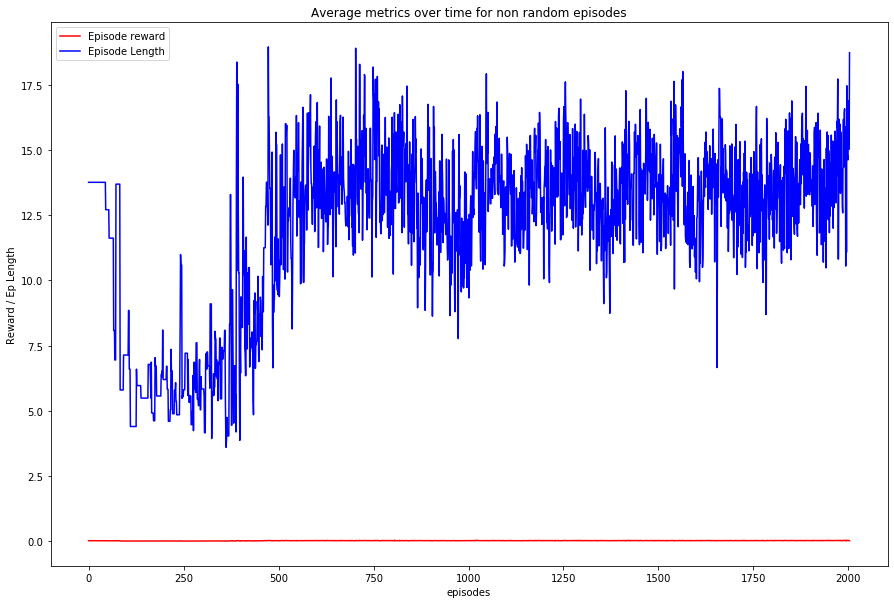

In [14]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrList)), AvgNonRandomrList, color='red', label='Episode reward')
plt.plot(range(len(AvgNonRandomsTimeList)), AvgNonRandomsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

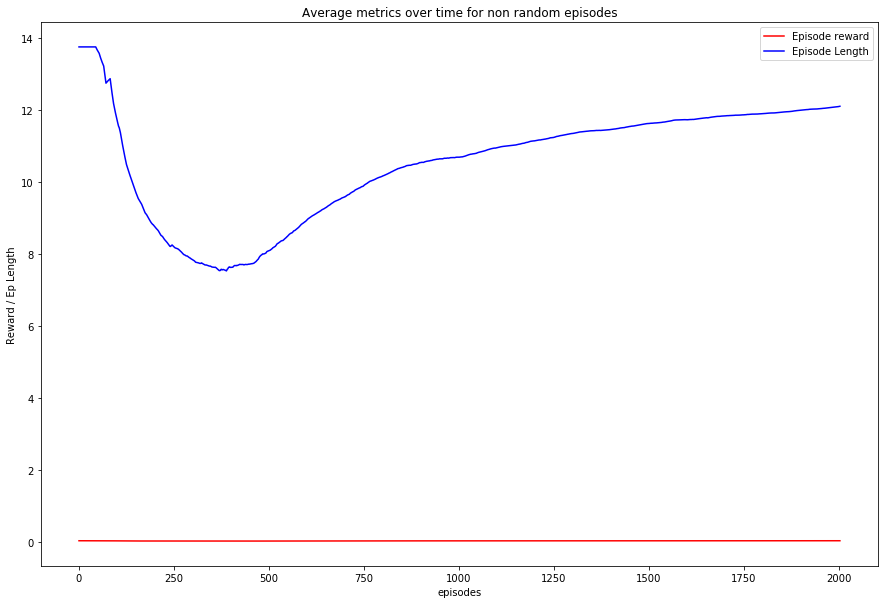

In [15]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrListMA)), AvgNonRandomrListMA, color='red', label='Episode reward')
plt.plot(range(len(AvgNonRandomsTimeListMA)), AvgNonRandomsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

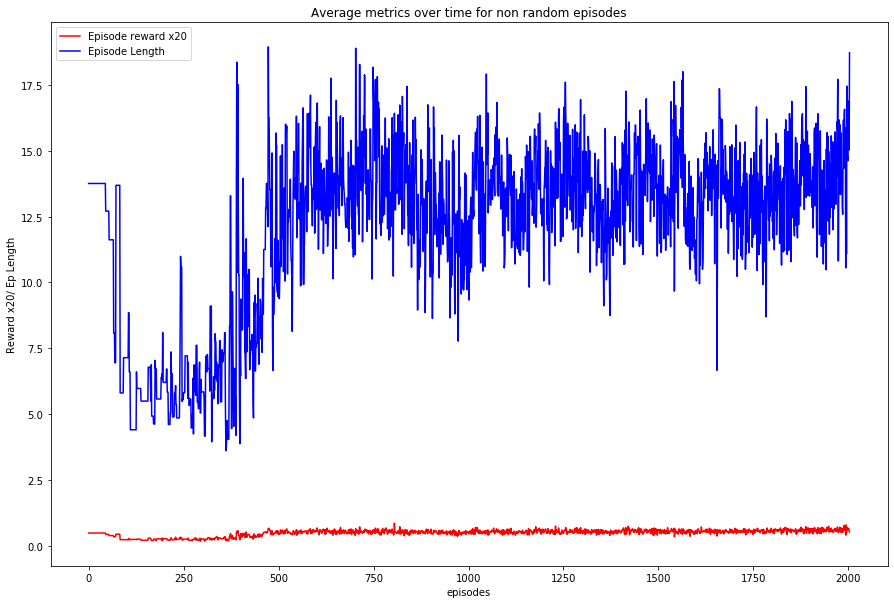

In [16]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrList)), np.array(AvgNonRandomrList)*20, color='red', label='Episode reward x20')
plt.plot(range(len(AvgNonRandomsTimeList)), AvgNonRandomsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward x20/ Ep Length')
plt.legend(loc='best');

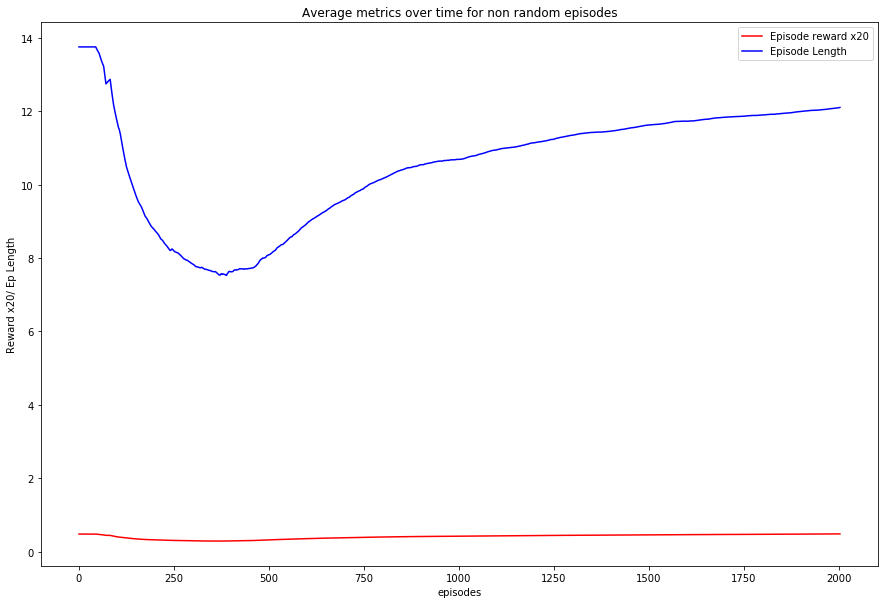

In [17]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrListMA)), np.array(AvgNonRandomrListMA)*20, color='red', label='Episode reward x20')
plt.plot(range(len(AvgNonRandomsTimeListMA)), AvgNonRandomsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward x20/ Ep Length')
plt.legend(loc='best');

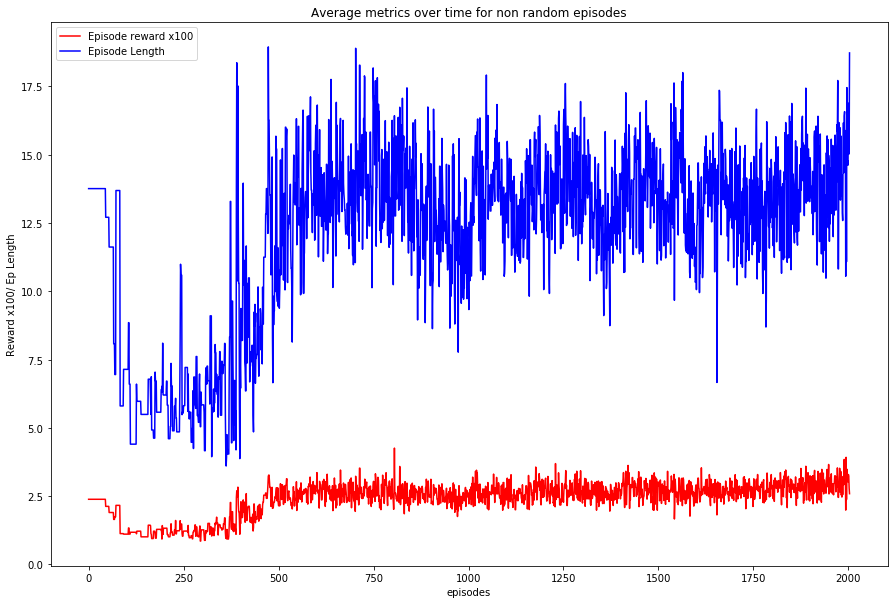

In [18]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrList)), np.array(AvgNonRandomrList)*100, color='red', label='Episode reward x100')
plt.plot(range(len(AvgNonRandomsTimeList)), AvgNonRandomsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward x100/ Ep Length')
plt.legend(loc='best');

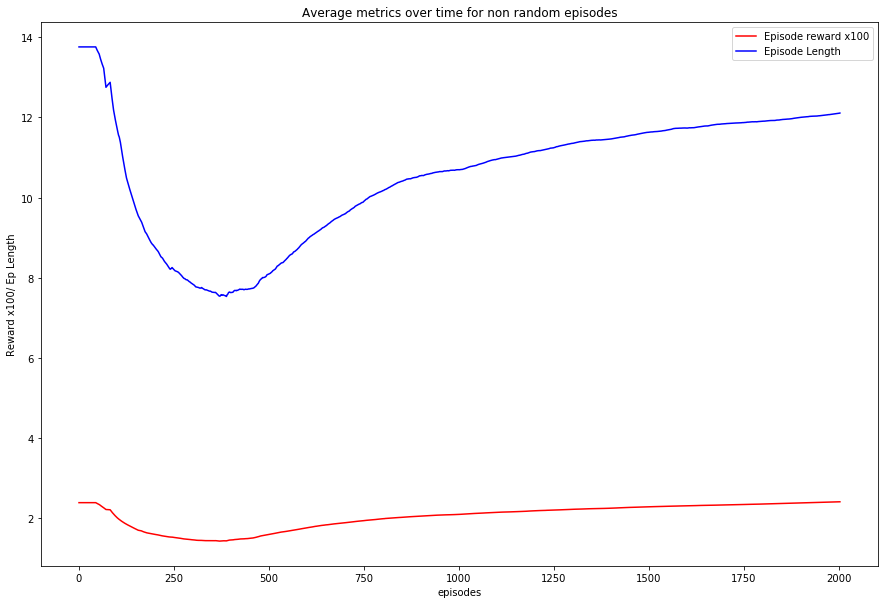

In [19]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrListMA)), np.array(AvgNonRandomrListMA)*100, color='red', label='Episode reward x100')
plt.plot(range(len(AvgNonRandomsTimeListMA)), AvgNonRandomsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward x100/ Ep Length')
plt.legend(loc='best');

# per epoch

In [20]:
AvgrListMAEpoch = movingaverage(AvgrListEpoch)

AvgsTimeListMAEpoch = movingaverage(AvgsTimeListEpoch)

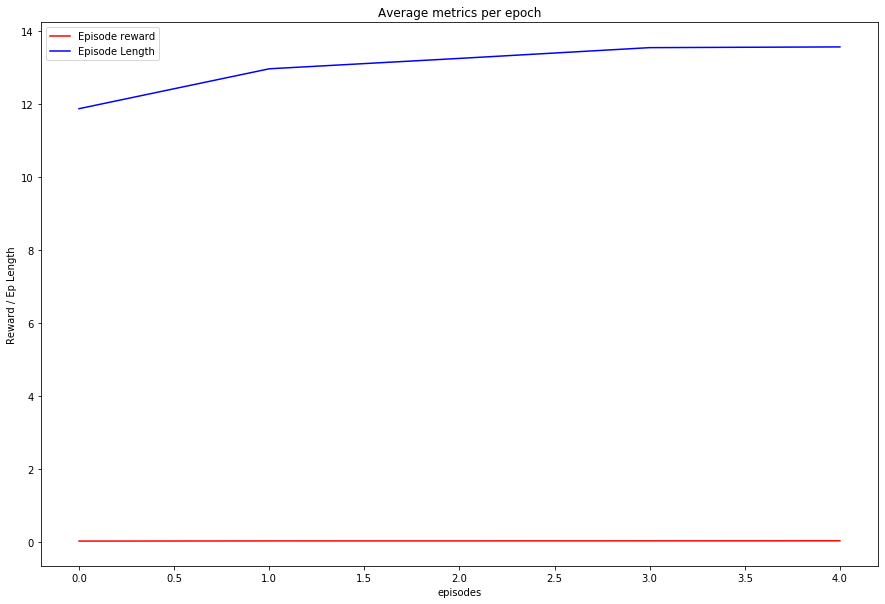

In [21]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgrListEpoch)), AvgrListEpoch, color='red', label='Episode reward')
plt.plot(range(len(AvgsTimeListEpoch)), AvgsTimeListEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

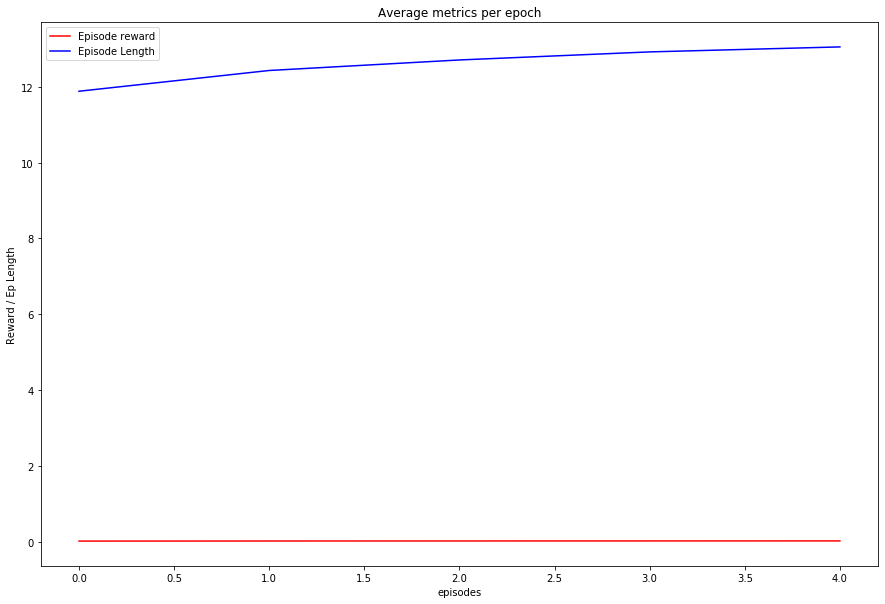

In [22]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgrListMAEpoch)), AvgrListMAEpoch, color='red', label='Episode reward')
plt.plot(range(len(AvgsTimeListMAEpoch)), AvgsTimeListMAEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

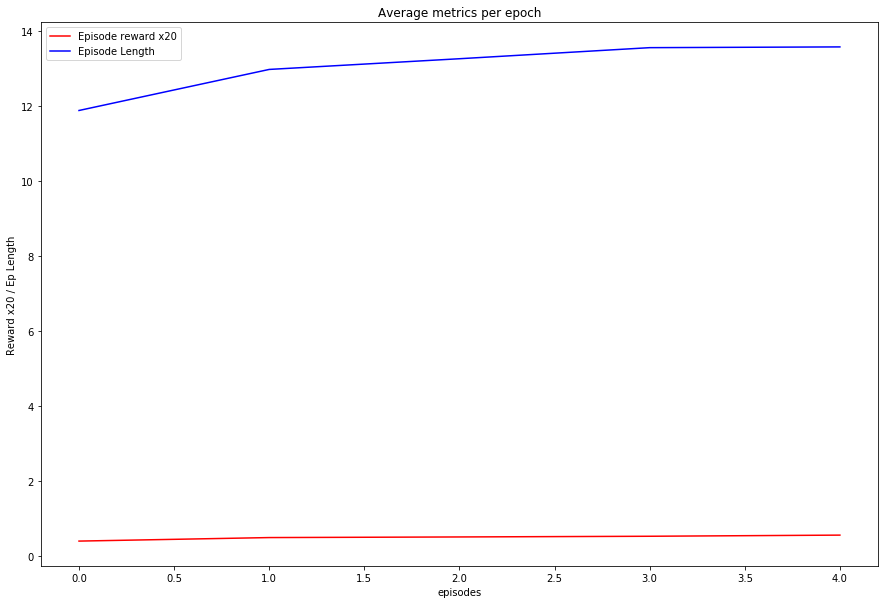

In [23]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgrListEpoch)), np.array(AvgrListEpoch)*20, color='red', label='Episode reward x20')
plt.plot(range(len(AvgsTimeListEpoch)), AvgsTimeListEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

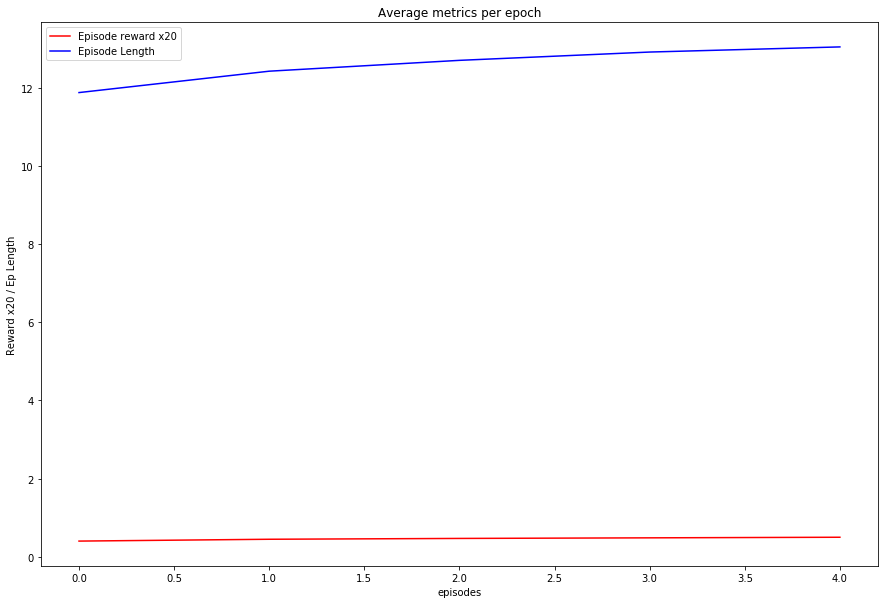

In [24]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgrListMAEpoch)), np.array(AvgrListMAEpoch)*20, color='red', label='Episode reward x20')
plt.plot(range(len(AvgsTimeListMAEpoch)), AvgsTimeListMAEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

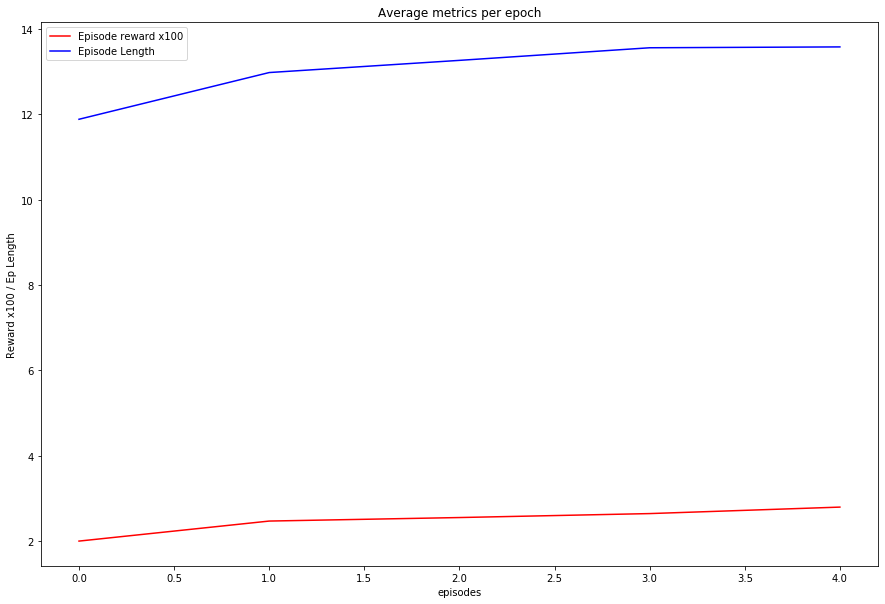

In [25]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
# plt.subplot(1,2,1);
plt.plot(range(len(AvgrListEpoch)), np.array(AvgrListEpoch)*100, color='red', label='Episode reward x100')
plt.plot(range(len(AvgsTimeListEpoch)), AvgsTimeListEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

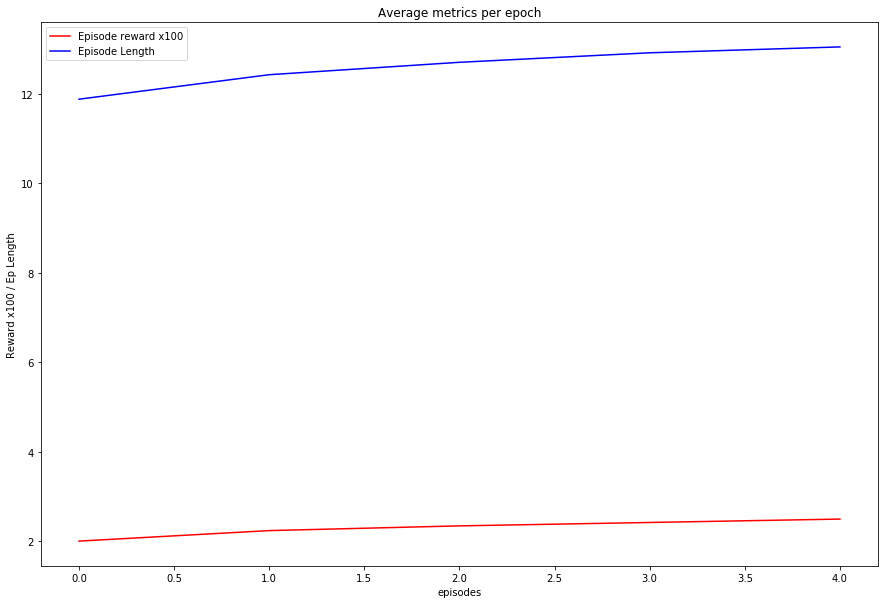

In [26]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
# plt.subplot(1,2,1);
plt.plot(range(len(AvgrListMAEpoch)), np.array(AvgrListMAEpoch)*100, color='red', label='Episode reward x100')
plt.plot(range(len(AvgsTimeListMAEpoch)), AvgsTimeListMAEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

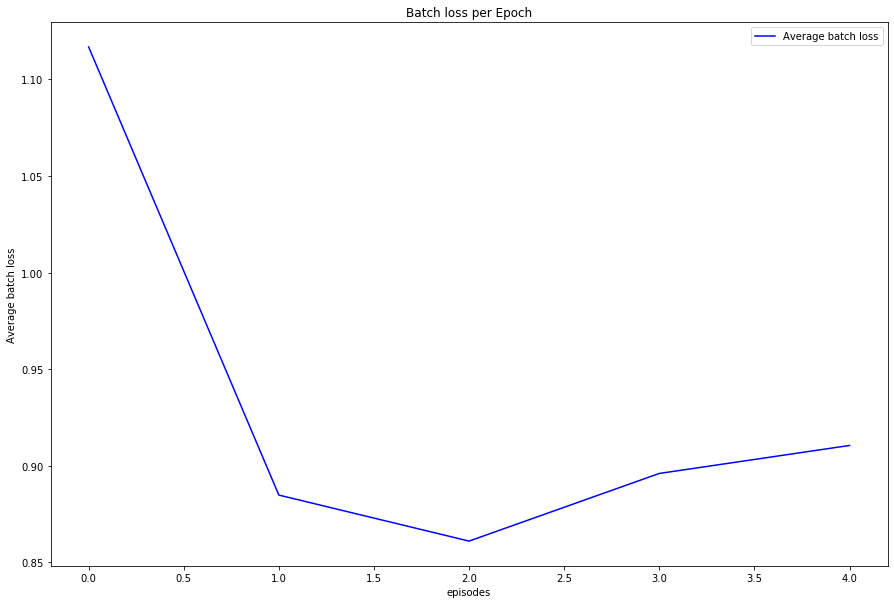

In [27]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgLossListEpoch)), AvgLossListEpoch, color='blue', label='Average batch loss')
#plt.plot(range(len(AvgQSellLossList)), AvgQSellLossList, color='red', label='Average batch loss for sell')
plt.title('Batch loss per Epoch')
plt.xlabel('episodes')
plt.ylabel('Average batch loss')
plt.legend(loc='best');

In [28]:
AvgrListMA = movingaverage(AvgrList)

AvgsTimeListMA = movingaverage(AvgsTimeList)

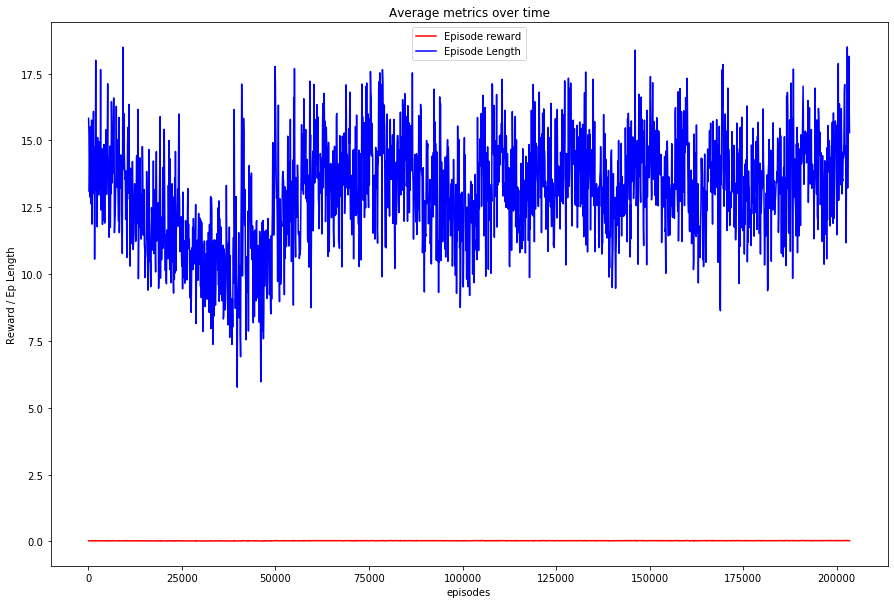

In [29]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

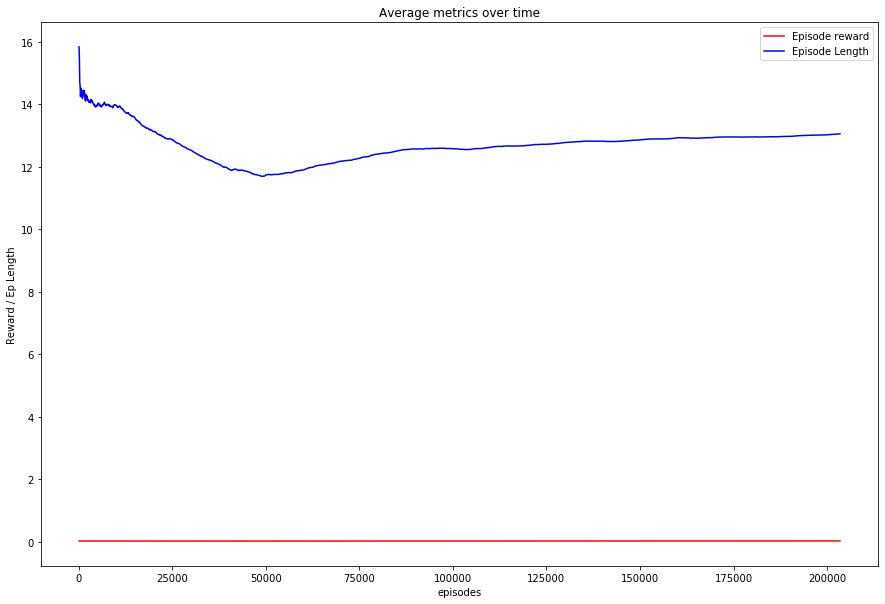

In [30]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrListMA, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

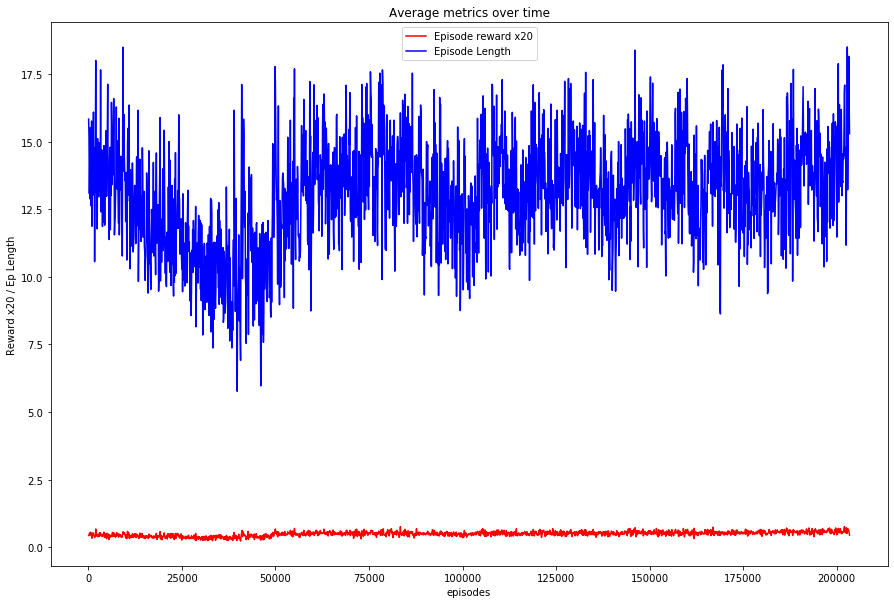

In [31]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

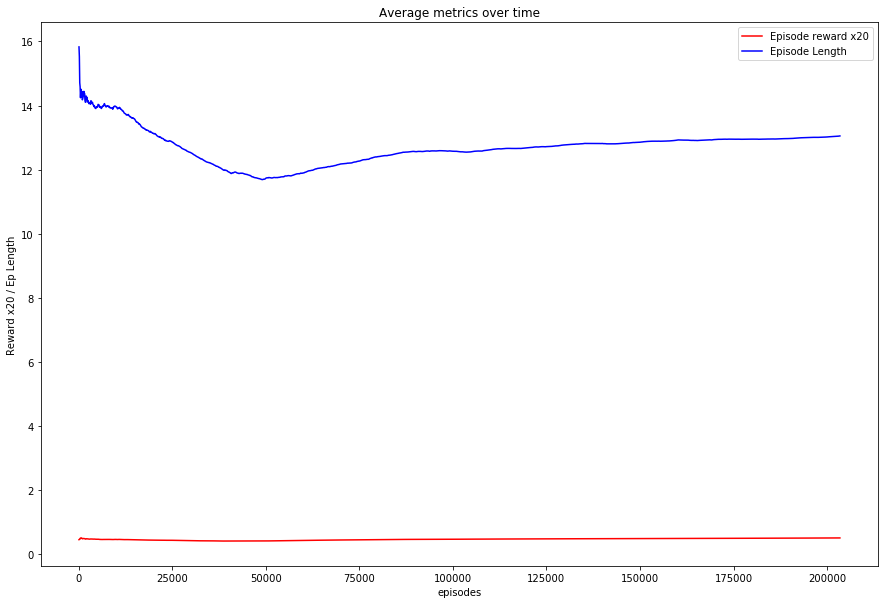

In [32]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrListMA)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

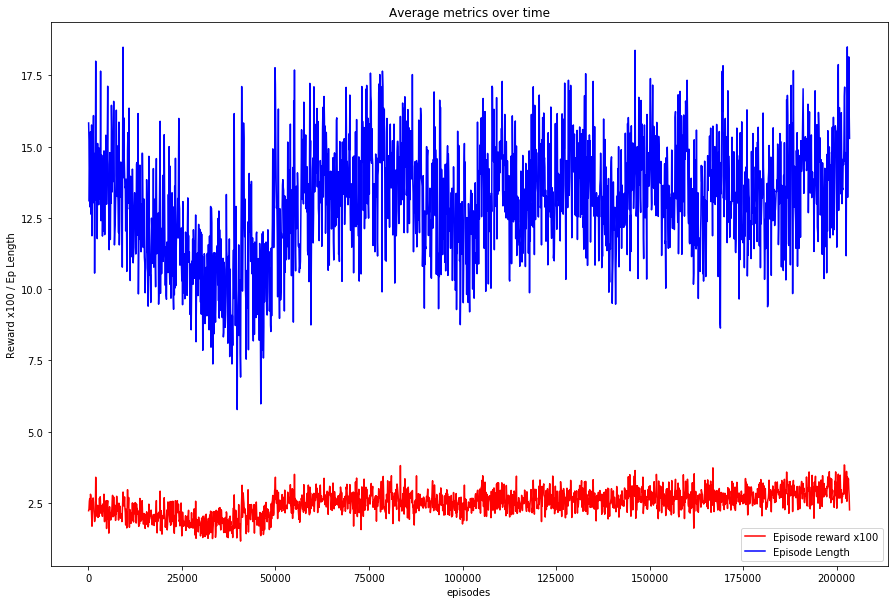

In [33]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
# plt.subplot(1,2,1);
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

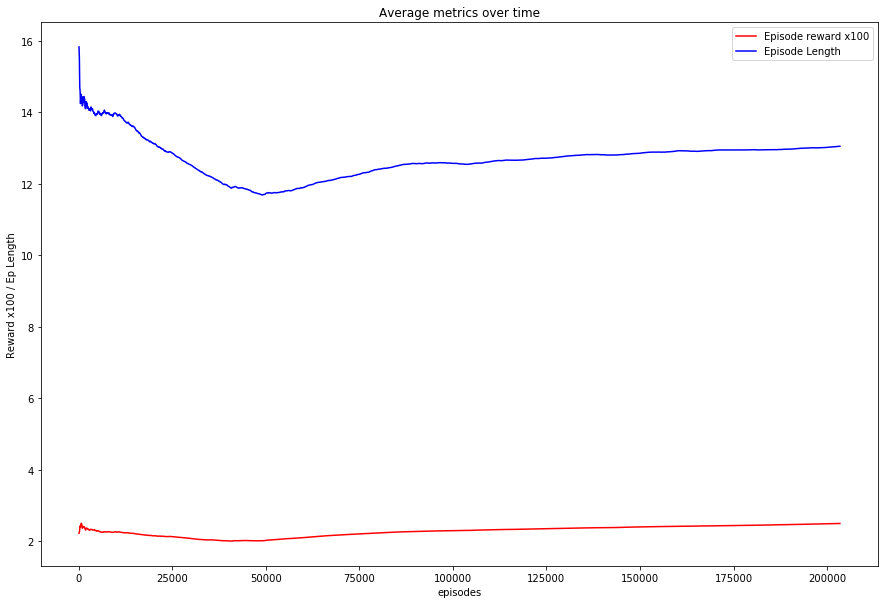

In [34]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
# plt.subplot(1,2,1);
plt.plot(AvgEpisodeList, np.array(AvgrListMA)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

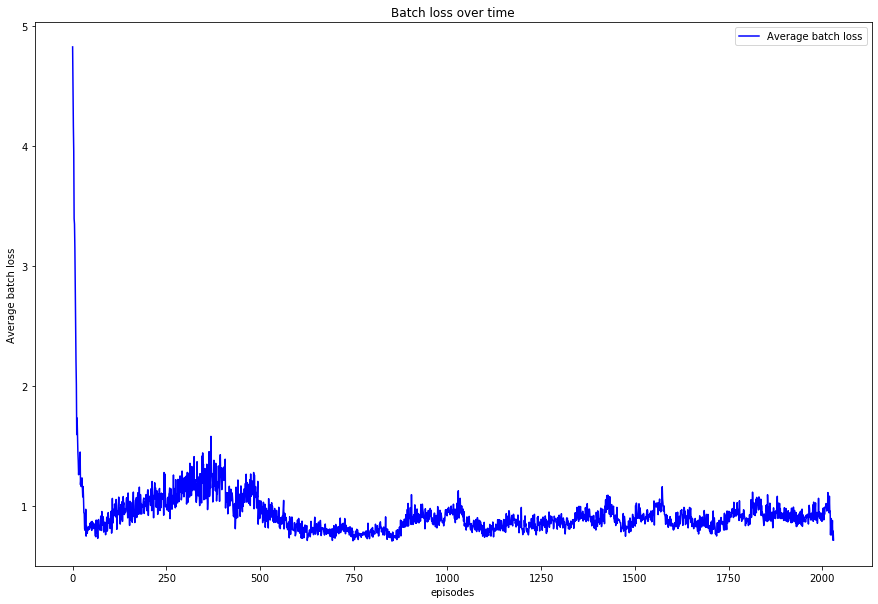

In [35]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgLossList)), AvgLossList, color='blue', label='Average batch loss')
#plt.plot(range(len(AvgQSellLossList)), AvgQSellLossList, color='red', label='Average batch loss for sell')
plt.title('Batch loss over time')
plt.xlabel('episodes')
plt.ylabel('Average batch loss')
plt.legend(loc='best');

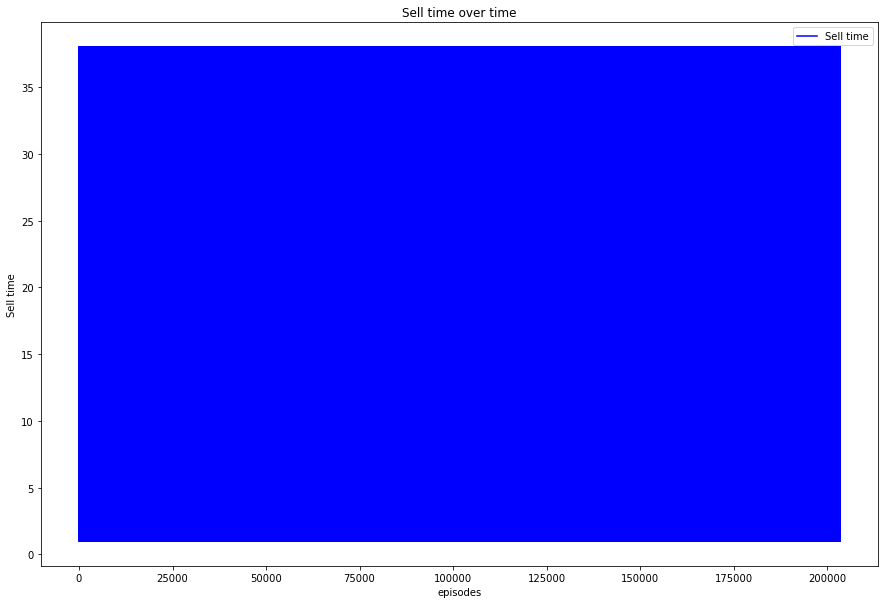

In [36]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

In [37]:
sTimeListMA = movingaverage(sTimeList)

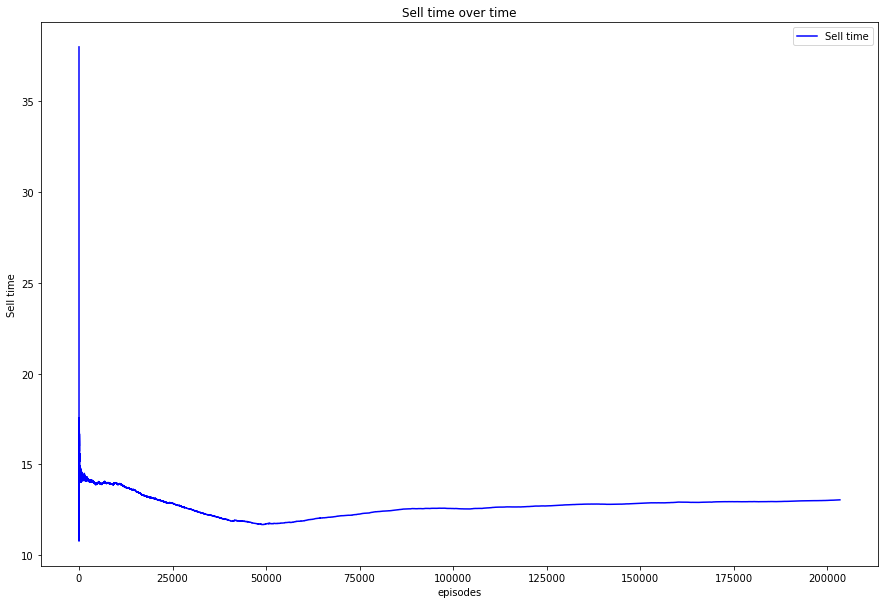

In [38]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeListMA)), sTimeListMA, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

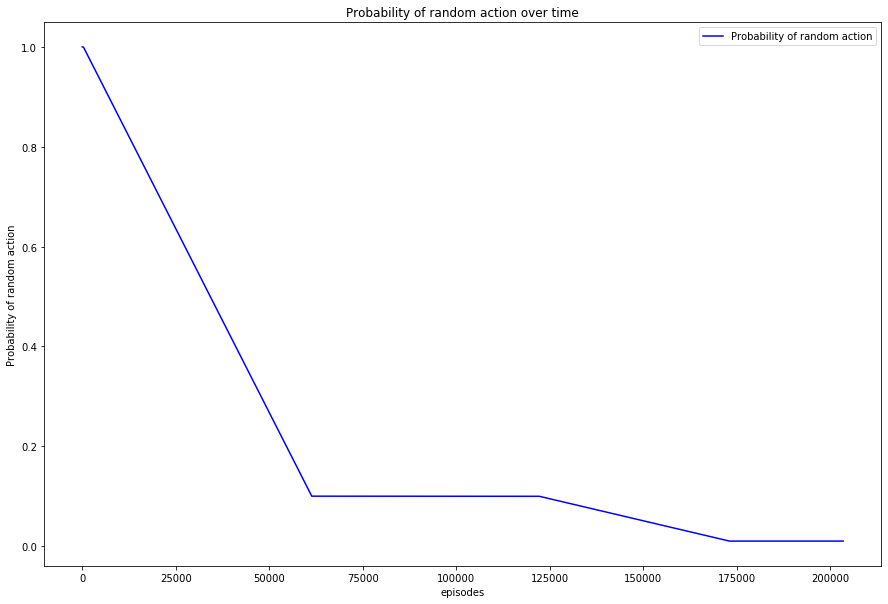

In [39]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(num_episodes), eList, color='blue', label='Probability of random action')
plt.title('Probability of random action over time')
plt.xlabel('episodes')
plt.ylabel('Probability of random action')
plt.legend(loc='best');

### Testing the network

In [40]:
#e = 0.03 #0.01 #The chance of chosing a random action
load_model = True #Whether to load a saved model.
is_training = False

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 112
num_episodes_per_epoch: 7200
min value of stock: 43.94938425447565, max value of stock: 55.55956501269605


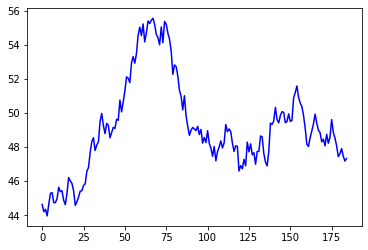

In [41]:
env = StockEnv(stocks_test_data, real_stocks_test_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(test_data)), test_data, color='b')

In [42]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:1'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                else:
                    a = a[0]
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Number of short selling: " + str(num_short_sell))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Loading Model...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /misc/scratch05/patx/fathanab/Experiments_RL/normalizeFirstDay_seed_corrected_2019_11_21_shuffled_GBM_version/savedModel/C51_noSoft_arch0-option_T50-history_t15-num_episodes203400-softUpdateFalse-tau0.001-dropout0.19999999999999996True-num_layers3-freq30-batch64-capacity3000-lambda0.0025-final
episode 100: 	0.028796603103565636	19.17
episode 200: 	0.017545197594413434	13.54
episode 300: 	0.02558091383303474	16.27
episode 400: 	0.029004879968293776	18.47
episode 500: 	0.024801737881155556	16.1
episode 600: 	0.023976765929158487	14.31
episode 700: 	0.024983631462035562	17.33
episode 800: 	0.02768534246391049	16.25
episode 900: 	0.024830826579059065	17.38
episode 1000: 	0.02825860226669038	18.17
episode 1100: 	0.021410917697062683	14.22
episode 1200: 	0.031182323124261155	18.42
episode 1300: 	0.024219056507820146	17.58
episode 1400: 	0.021917984

In [43]:
# Normal Test
# 4000 episodes
#Average reward per episode: -0.0004459820152409164%
#Time to execute: 1.0273285110791524min

# 10000 episodes of training (23000 episodes)
#Average reward per episode: -0.0006903839079534307%
#Time to execute: 18.210397080580393min

# 30000 episodes of training (23000 episodes)
#Average reward per episode: -0.0015529333479744412%
#Time to execute: 27.645483565330505min

# 20000 episodes of training
#Average reward per episode: -0.0049713977980137885%
#Time to execute: 31.664522131284077min

# 100000 episodes of training # architecture 0
#Total average reward per episode: -0.0031459276190924593
#Time to execute: 27.598839151859284min

#20000 episodes training
#Total average reward per episode: 0.0024760915583103395
#Time to execute: 2.219494903087616min

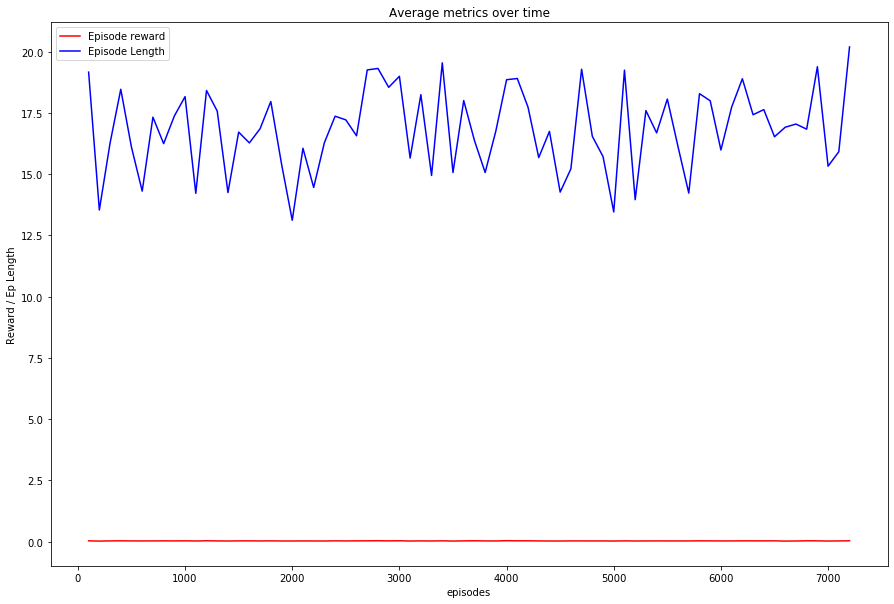

In [44]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

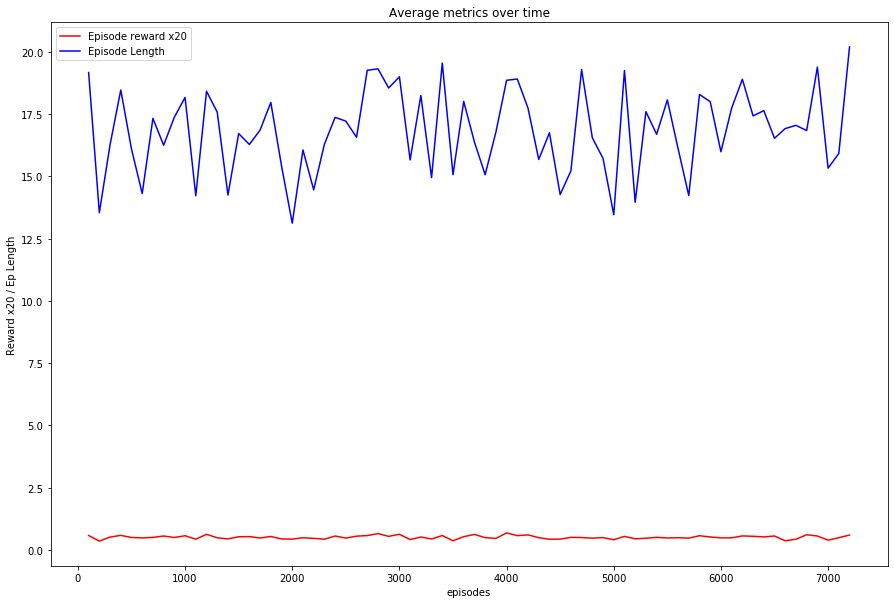

In [45]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

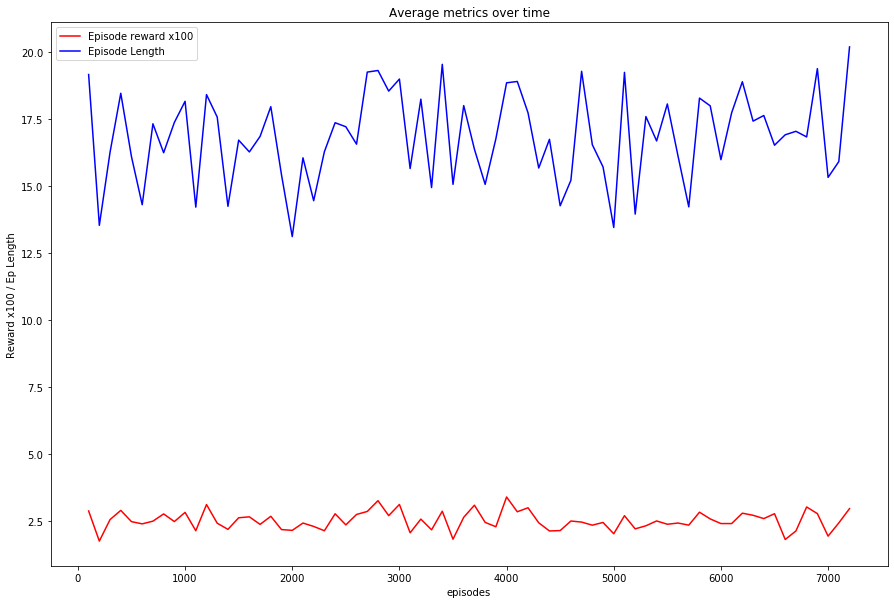

In [46]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

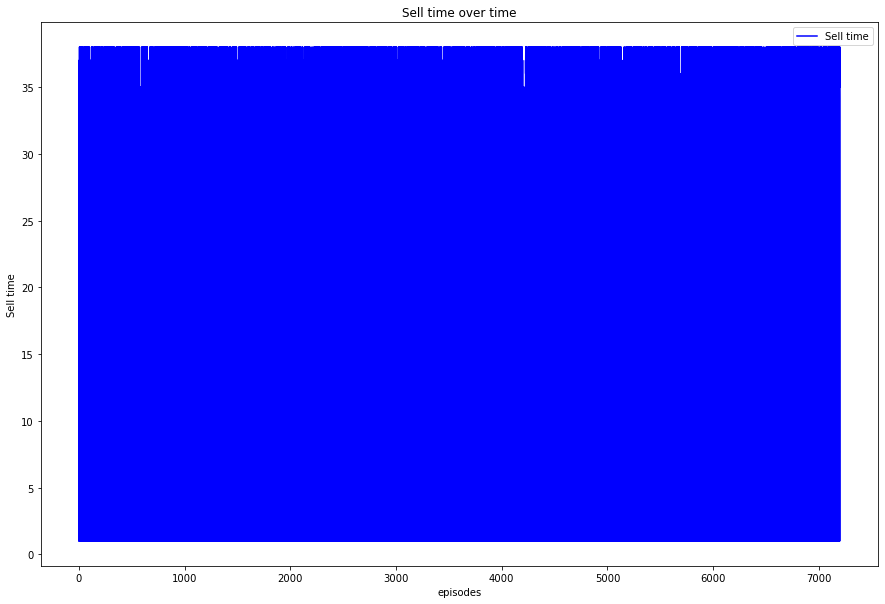

In [47]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select day of Max price over history [Benchmark]

In [48]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
# Have a look at the RL notebook for more correct tests (slightly changed)
begin_time = time.time()

test = 'MaxValue' #'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:1'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(1,max_epLength - 1)
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break

        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.026659417514364115	20.61	0.009999410030107894
episode 200: 	0.018244488582935776	14.69	0.009999410030107894
episode 300: 	0.024449723013993556	17.65	0.009999410030107894
episode 400: 	0.027780260636203476	20.24	0.009999410030107894
episode 500: 	0.026283018203706144	17.28	0.009999410030107894
episode 600: 	0.023986623561206667	15.43	0.009999410030107894
episode 700: 	0.023976726431810483	19.13	0.009999410030107894
episode 800: 	0.027202398047265673	17.28	0.009999410030107894
episode 900: 	0.023789942802023022	18.02	0.009999410030107894
episode 1000: 	0.028275258066205223	19.5	0.009999410030107894
episode 1100: 	0.02024933599084934	15.06	0.009999410030107894
episode 1200: 	0.02857855141579651	19.5	0.009999410030107894
episode 1300: 	0.02556385320959215	18.76	0.009999410030107894
episode 1400: 	0.020758108434256836	15.43	0.009999410030107894
episode 1500: 	0.02519586951253231	18.39	0.009999410030107894
episode 1600: 	0.02785573210437634	17.65	0.009999410030107894
episode 

In [49]:
# 4000 episodes
# Select state of Max price over history [Benchmark]
#Average reward per episode: 0.0005877807673596729%
#Time to execute: 0.09947771628697713min

# 10000 episodes of training
#Average reward per episode: 0.0004938414456624297%
#Time to execute: 0.5947879354159037min

# 23000 episodes of training
#Average reward per episode: 0.0005705326210584273%
#Time to execute: 0.8882605234781901min

# 23000 episodes
#Average reward per episode: 0.0010192164676906157%
#Time to execute: 0.5056182742118835min

# 23000 episodes
#Total average reward per episode: 0.0009947041707927247
#Time to execute: 0.6030449350674947min

# 23000 episodes
#Total average reward per episode: 0.0009401450698119521
#Time to execute: 0.9448242465655009min

# 23000 episodes
#Total average reward per episode: 0.0003986495802468716
#Time to execute: 0.5700281739234925min

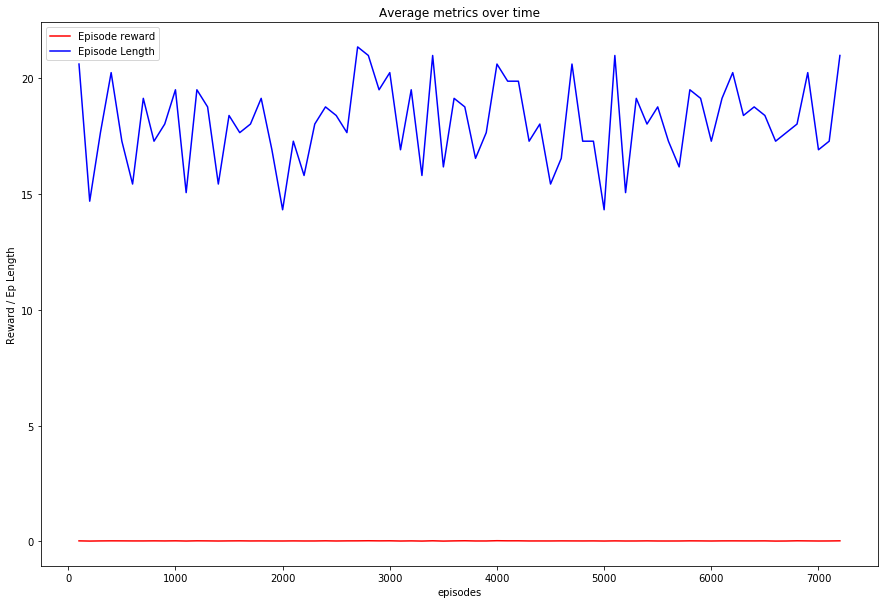

In [50]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

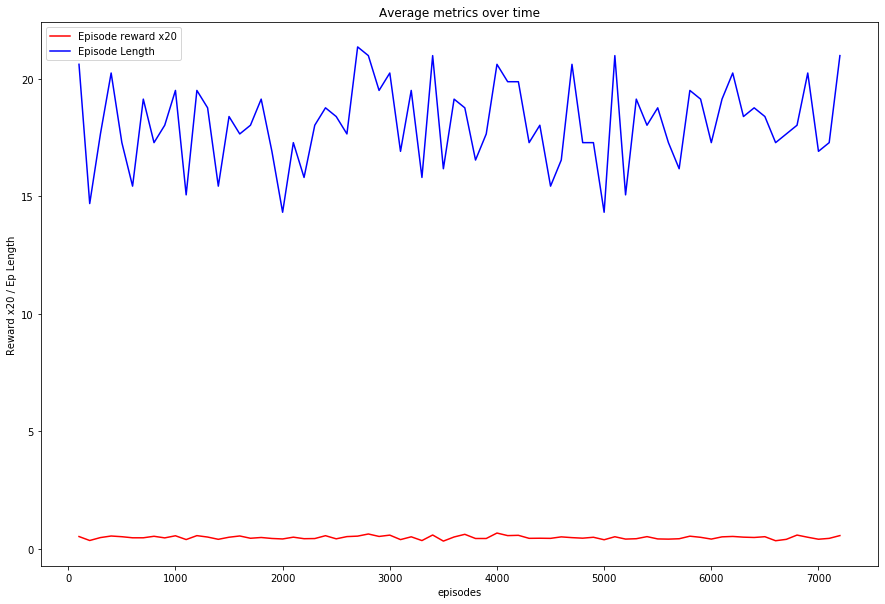

In [51]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

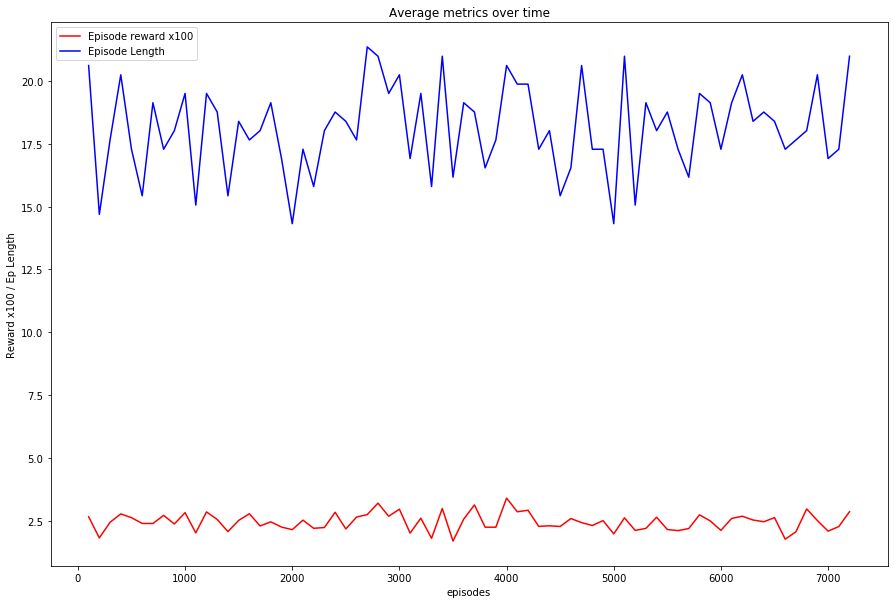

In [52]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

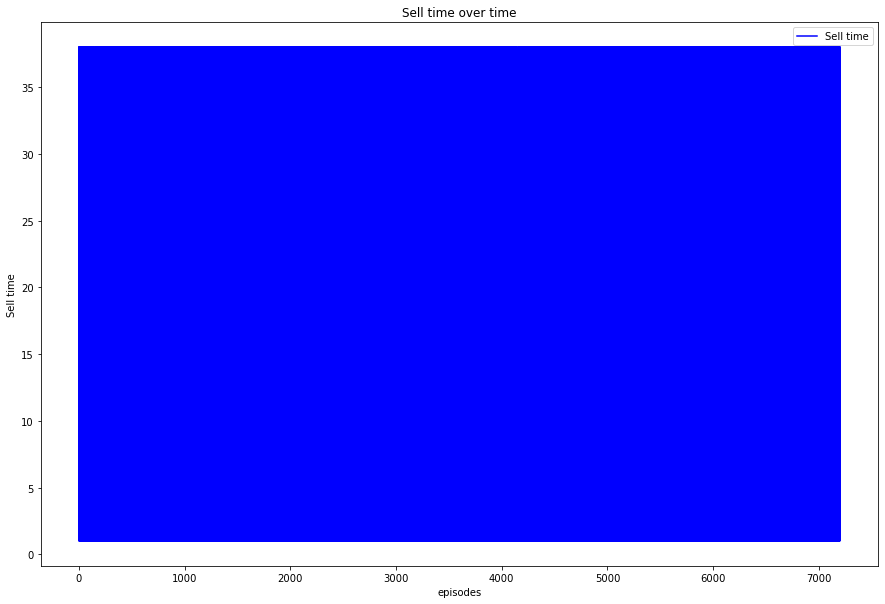

In [53]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select random day over history to sell [Benchmark]

In [54]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
begin_time = time.time()

test = 'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:1'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(1,max_epLength - 1)
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)
        
        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))    

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.022895674989415523	16.1	0.009999410030107894
episode 200: 	0.019360352609019263	12.26	0.009999410030107894
episode 300: 	0.02603824426932976	14.77	0.009999410030107894
episode 400: 	0.027129658995760718	17.73	0.009999410030107894
episode 500: 	0.021770893935129938	13.99	0.009999410030107894
episode 600: 	0.02096899117918432	13.96	0.009999410030107894
episode 700: 	0.020988505636816205	14.72	0.009999410030107894
episode 800: 	0.02410571134170965	14.15	0.009999410030107894
episode 900: 	0.021549148659961923	15.28	0.009999410030107894
episode 1000: 	0.026665299695691525	18.21	0.009999410030107894
episode 1100: 	0.02087686994135424	13.07	0.009999410030107894
episode 1200: 	0.026319248491798574	15.87	0.009999410030107894
episode 1300: 	0.02400042202478191	15.66	0.009999410030107894
episode 1400: 	0.019923006800994812	13.34	0.009999410030107894
episode 1500: 	0.023254327188040214	15.79	0.009999410030107894
episode 1600: 	0.02367033071010851	13.9	0.009999410030107894
episode 1

In [55]:
# 4000 episodes
# Select random state over history [Benchmark]
#Average reward per episode: 0.0015505754102431175%
#Time to execute: 0.07682177225748697min

#23000 episodes
# Average reward per episode: 0.0012894304336377236%
#Time to execute: 0.40911168257395425min

#23000 episodes
#Average reward per episode: 0.002274329489706149%
#Time to execute: 0.6566788395245869min

#23000 episodes
#Average reward per episode: 0.001215791565711024%
#Time to execute: 0.36365593671798707min

# 23000 episodes
#Total average reward per episode: 0.00036678919435973405
#Time to execute: 0.4333968202273051min

# 23000 episodes
#Total average reward per episode: 0.0010562361629312214
#Time to execute: 0.6513438741366069min

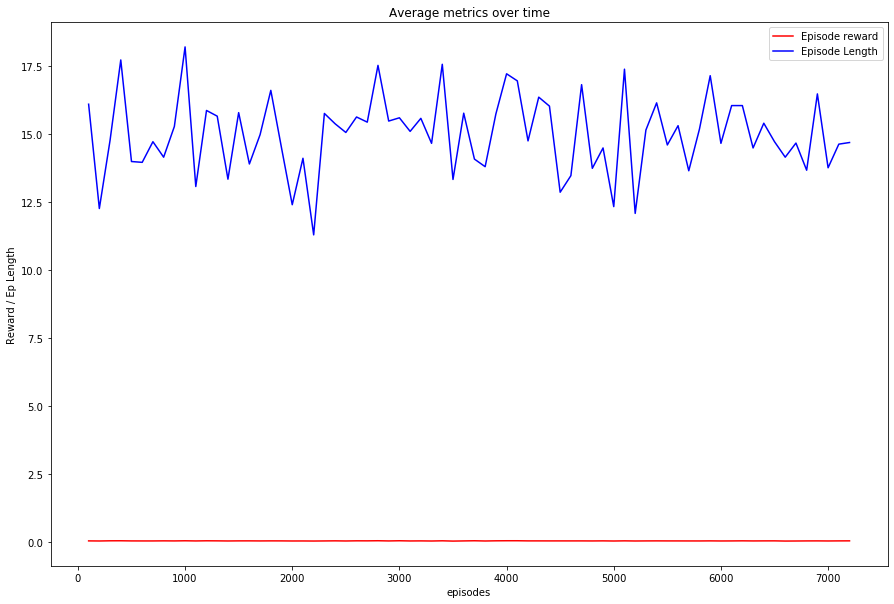

In [56]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

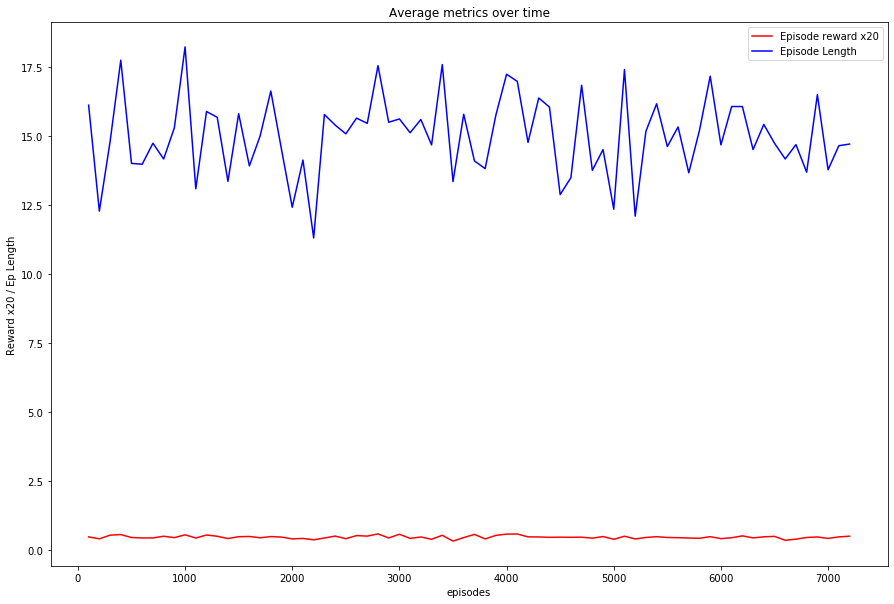

In [57]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

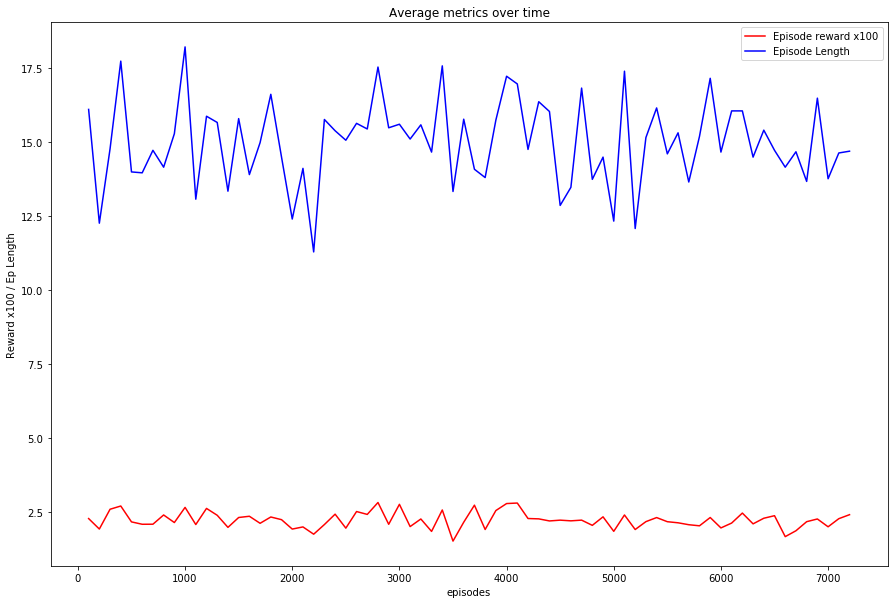

In [58]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

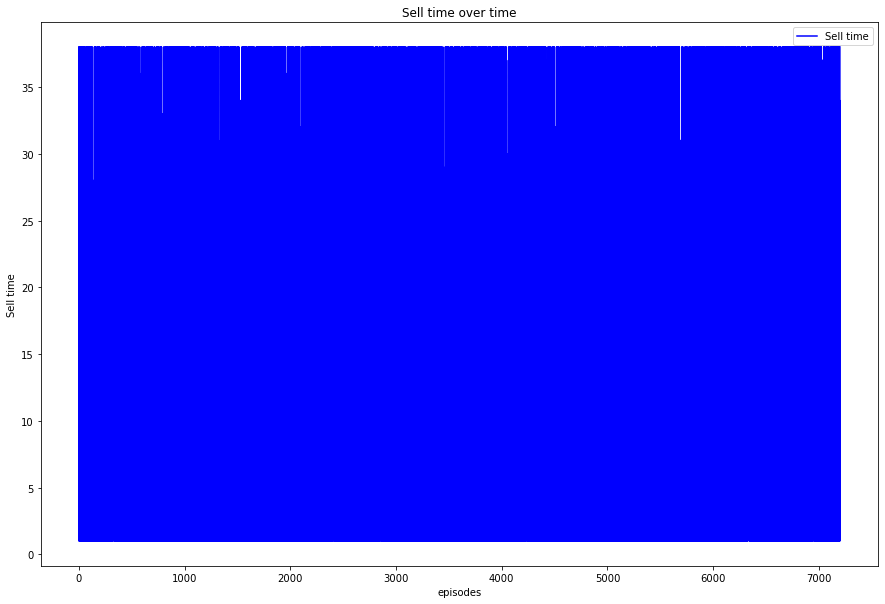

In [59]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select last day over history to sell [Benchmark]

In [60]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
begin_time = time.time()

test = 'LastDay'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []  

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

with tf.Session() as sess, tf.device('/gpu:1'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(1,max_epLength - 1)
        elif test == 'LastDay':
          sell_time = max_epLength - 1  
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random' or test == 'LastDay':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)

            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.026659417514364115	20.61	0.009999410030107894
episode 200: 	0.018244488582935776	14.69	0.009999410030107894
episode 300: 	0.024449723013993556	17.65	0.009999410030107894
episode 400: 	0.027780260636203476	20.24	0.009999410030107894
episode 500: 	0.026283018203706144	17.28	0.009999410030107894
episode 600: 	0.023986623561206667	15.43	0.009999410030107894
episode 700: 	0.023976726431810483	19.13	0.009999410030107894
episode 800: 	0.027202398047265673	17.28	0.009999410030107894
episode 900: 	0.023789942802023022	18.02	0.009999410030107894
episode 1000: 	0.028275258066205223	19.5	0.009999410030107894
episode 1100: 	0.02024933599084934	15.06	0.009999410030107894
episode 1200: 	0.02857855141579651	19.5	0.009999410030107894
episode 1300: 	0.02556385320959215	18.76	0.009999410030107894
episode 1400: 	0.020758108434256836	15.43	0.009999410030107894
episode 1500: 	0.02519586951253231	18.39	0.009999410030107894
episode 1600: 	0.02785573210437634	17.65	0.009999410030107894
episode 

In [61]:
# 4600 episodes
#Average reward per episode: 0.001350523388538691%
#Time to execute: 0.08548296292622884min

#23000 episodes
#Average reward per episode: 0.002919471458257028%
#Time to execute: 0.32947063048680625min

# 23000 episodes
#Total average reward per episode: 0.003380776061516078
#Time to execute: 0.36532406012217206min

# 23000 episodes
#Total average reward per episode: 0.002987836452606828
#Time to execute: 0.5932944019635519min

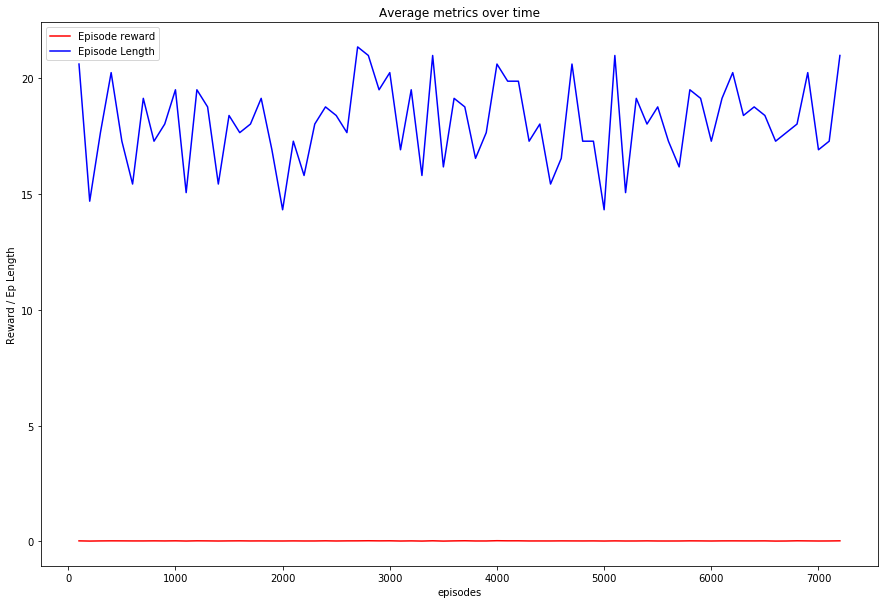

In [62]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

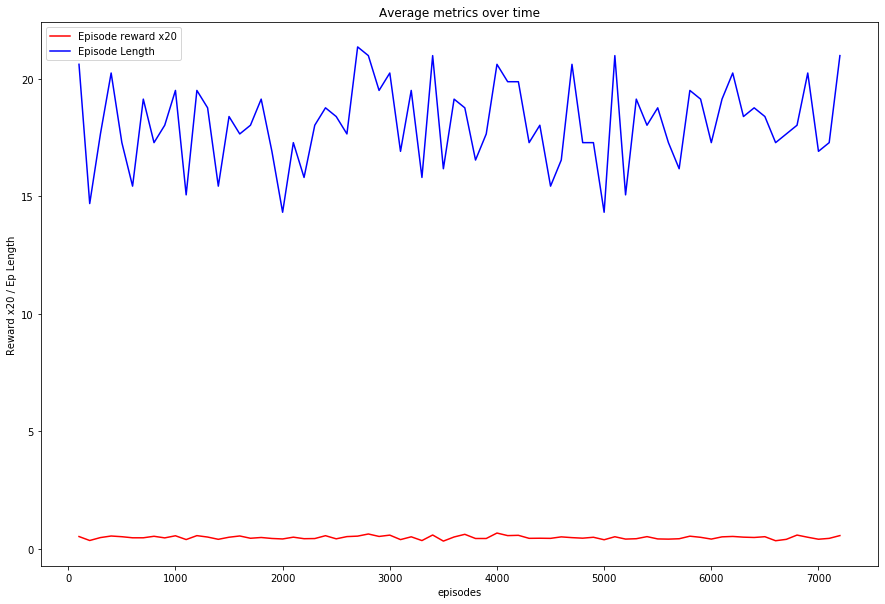

In [63]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

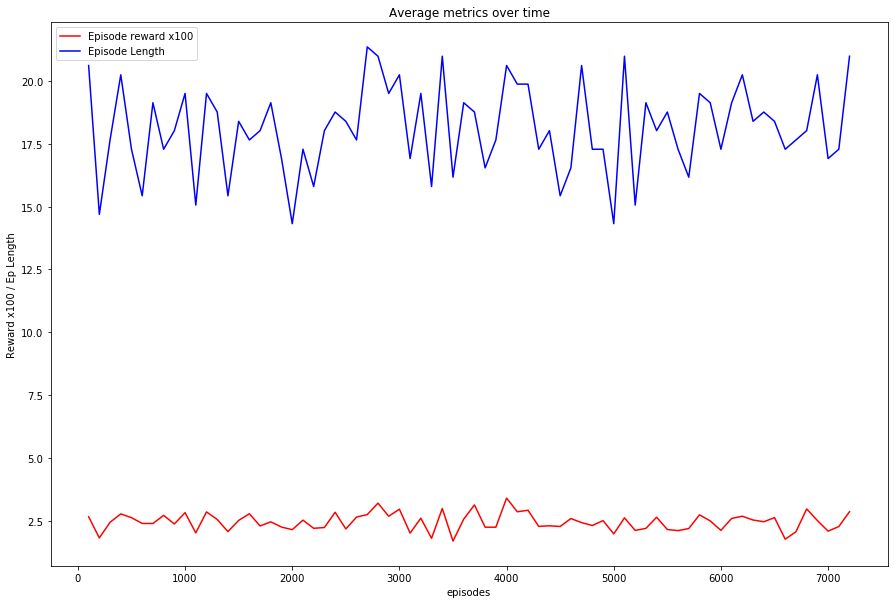

In [64]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

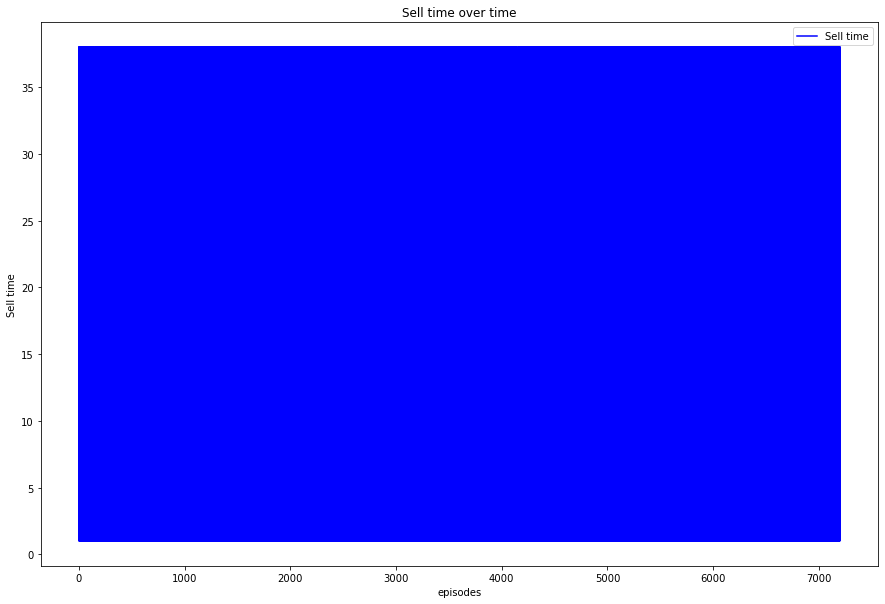

In [65]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Validation part

In [66]:
"""stock_names = ['t.us.txt', 'gm.us.txt', 'cvs.us.txt', 'unh.us.txt',
               'xom.us.txt', 'brk-a.us.txt', 'wmt.us.txt', 'mck.us.txt',
               'aat.us.txt', 'abc.us.txt', 'acre.us.txt', 'acta.us.txt',
               'fn.us.txt','fnb.us.txt', 'ford.us.txt', 'krg.us.txt',
              'pay.us.txt', 'peg.us.txt', 'tg.us.txt', 'tis.us.txt',
              'nflx.us.txt', 'acn.us.txt', 'utx.us.txt','lmt.us.txt',
              'nvda.us.txt', 'avgo.us.txt', 'azn.us.txt', 'tmo.us.txt',
               'unp.us.txt', 'lfc.us.txt', 'bhp.us.txt','sny.us.txt',
               'bbl.us.txt', 'ry.us.txt', 'asml.us.txt', 'nee.us.txt', 
              'txn.us.txt', 'gsk.us.txt', 'lly.us.txt', 'nvo.us.txt',
               'td.us.txt', 'qcom.us.txt', 'dhr.us.txt', 'chtr.us.txt',
               'sbux.us.txt', 'mmm.us.txt', 'axp.us.txt', 'hdb.us.txt',
              'csco.us.txt', 'orcl.us.txt', 'c.us.txt']
# unvalid stocks: 'kst.us.txt', 'ddt.us.txt', 'lgl.us.txt', 'aac.us.txt','adom.us.txt','acrs.us.txt', 'delt.us.txt', 'lcahu.us.txt', 'tpge.us.txt', 'wear.us.txt'

stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_name in stock_names:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(test_data)), test_data, color='r') """

"stock_names = ['t.us.txt', 'gm.us.txt', 'cvs.us.txt', 'unh.us.txt',\n               'xom.us.txt', 'brk-a.us.txt', 'wmt.us.txt', 'mck.us.txt',\n               'aat.us.txt', 'abc.us.txt', 'acre.us.txt', 'acta.us.txt',\n               'fn.us.txt','fnb.us.txt', 'ford.us.txt', 'krg.us.txt',\n              'pay.us.txt', 'peg.us.txt', 'tg.us.txt', 'tis.us.txt',\n              'nflx.us.txt', 'acn.us.txt', 'utx.us.txt','lmt.us.txt',\n              'nvda.us.txt', 'avgo.us.txt', 'azn.us.txt', 'tmo.us.txt',\n               'unp.us.txt', 'lfc.us.txt', 'bhp.us.txt','sny.us.txt',\n               'bbl.us.txt', 'ry.us.txt', 'asml.us.txt', 'nee.us.txt', \n              'txn.us.txt', 'gsk.us.txt', 'lly.us.txt', 'nvo.us.txt',\n               'td.us.txt', 'qcom.us.txt', 'dhr.us.txt', 'chtr.us.txt',\n               'sbux.us.txt', 'mmm.us.txt', 'axp.us.txt', 'hdb.us.txt',\n              'csco.us.txt', 'orcl.us.txt', 'c.us.txt']\n# unvalid stocks: 'kst.us.txt', 'ddt.us.txt', 'lgl.us.txt', 'aac.us.txt','adom.

min value of data: 149.18037629139917, max value of data: 256.56396432838824
train_size: 743
test_size: 185
min value of data: 146.40281438616097, max value of data: 243.09411459102242
train_size: 743
test_size: 185
min value of data: 159.6982075979734, max value of data: 280.9047648876022
train_size: 743
test_size: 185
min value of data: 60.78641635455478, max value of data: 139.73485854049807
train_size: 743
test_size: 185
min value of data: 55.61805768577872, max value of data: 82.00774049225886
train_size: 743
test_size: 185
min value of data: 52.47767896196799, max value of data: 87.04854401368696
train_size: 743
test_size: 185
min value of data: 119.18099473857227, max value of data: 193.51691176628293
train_size: 743
test_size: 185
min value of data: 189.34154799124755, max value of data: 407.31662039612075
train_size: 743
test_size: 185
min value of data: 76.1687706926376, max value of data: 148.2835419805423
train_size: 743
test_size: 185
min value of data: 49.5077309079945, m

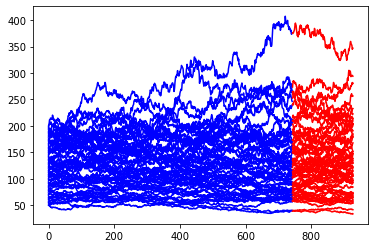

In [67]:
#Generate stocks data
stocks_data, _ = GBM(num_seeds, is_training).generate_stock_paths(mu, sigma, 928, num_seeds, is_training)
stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_data in stocks_data:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    #train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_data, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, color='r') 

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 112
num_episodes_per_epoch: 7200
min value of stock: 126.33635505966664, max value of stock: 153.29861211406774


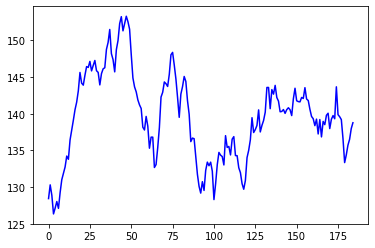

In [68]:
env = StockEnv(stocks_test_data, real_stocks_test_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(test_data)), test_data, color='b')

In [69]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:1'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                else:
                    a = a[0]
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Number of short selling: " + str(num_short_sell))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Loading Model...
INFO:tensorflow:Restoring parameters from /misc/scratch05/patx/fathanab/Experiments_RL/normalizeFirstDay_seed_corrected_2019_11_21_shuffled_GBM_version/savedModel/C51_noSoft_arch0-option_T50-history_t15-num_episodes203400-softUpdateFalse-tau0.001-dropout0.19999999999999996True-num_layers3-freq30-batch64-capacity3000-lambda0.0025-final
episode 100: 	0.03150814963627288	18.42
episode 200: 	0.026391229359134644	19.7
episode 300: 	0.034003313786028916	20.09
episode 400: 	0.03240987026677761	19.62
episode 500: 	0.029853880453079046	17.27
episode 600: 	0.027704586931136796	18.14
episode 700: 	0.030793383987346448	16.92
episode 800: 	0.030548616296578443	18.05
episode 900: 	0.029848825762100413	18.72
episode 1000: 	0.03258779330875007	20.54
episode 1100: 	0.035440520459622316	18.55
episode 1200: 	0.03328964949093258	17.4
episode 1300: 	0.03368140077603992	19.64
episode 1400: 	0.032177869365883655	19.15
episode 1500: 	0.02906545896781922	16.5
episode 1600: 	0.03350050653090183

In [70]:
# Normal Test
# 4000 episodes
#Average reward per episode: -0.0004459820152409164%
#Time to execute: 1.0273285110791524min

# 10000 episodes of training (23000 episodes)
#Average reward per episode: -0.0006903839079534307%
#Time to execute: 18.210397080580393min

# 30000 episodes of training (23000 episodes)
#Average reward per episode: -0.0015529333479744412%
#Time to execute: 27.645483565330505min

# 20000 episodes of training
#Average reward per episode: -0.0049713977980137885%
#Time to execute: 31.664522131284077min

# 100000 episodes of training # architecture 0
#Total average reward per episode: -0.0031459276190924593
#Time to execute: 27.598839151859284min

#20000 episodes training
#Total average reward per episode: 0.0024760915583103395
#Time to execute: 2.219494903087616min

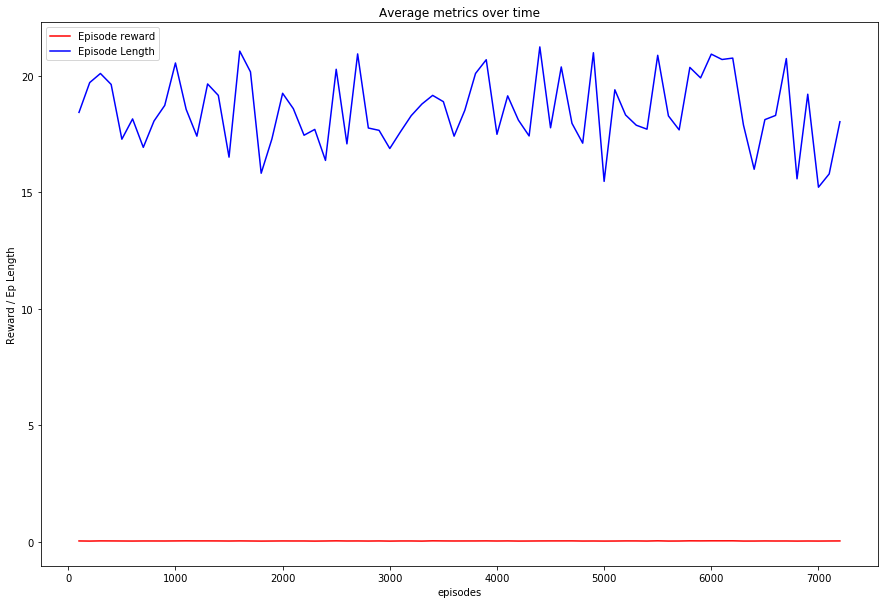

In [71]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

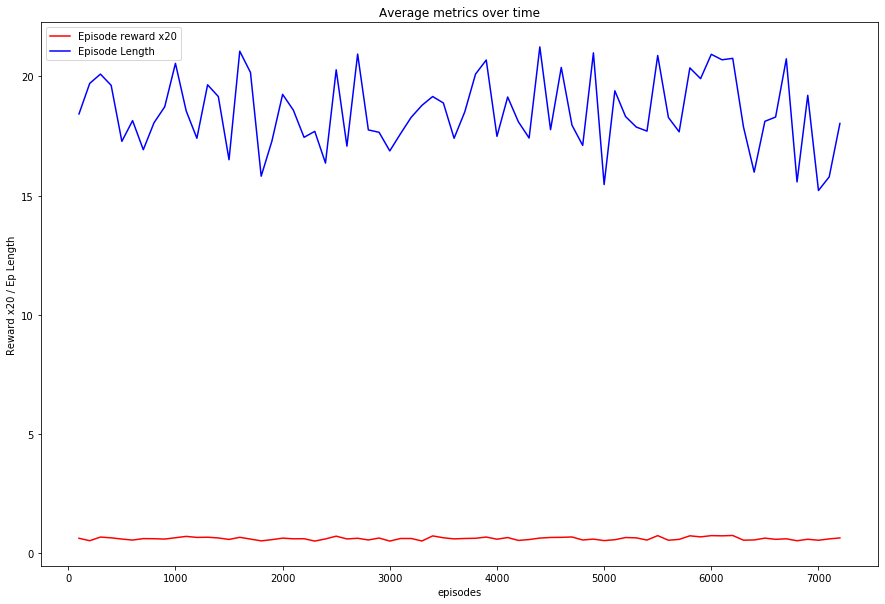

In [72]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

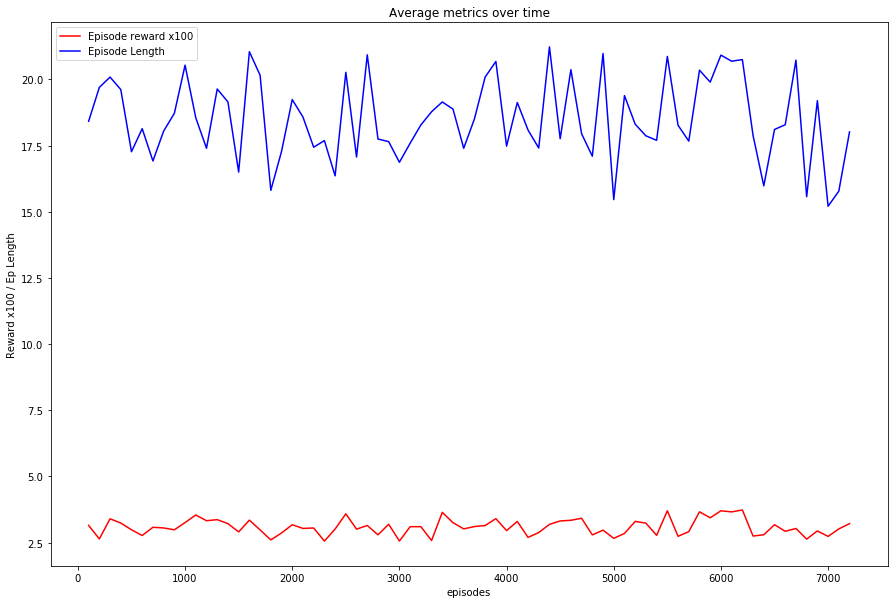

In [73]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

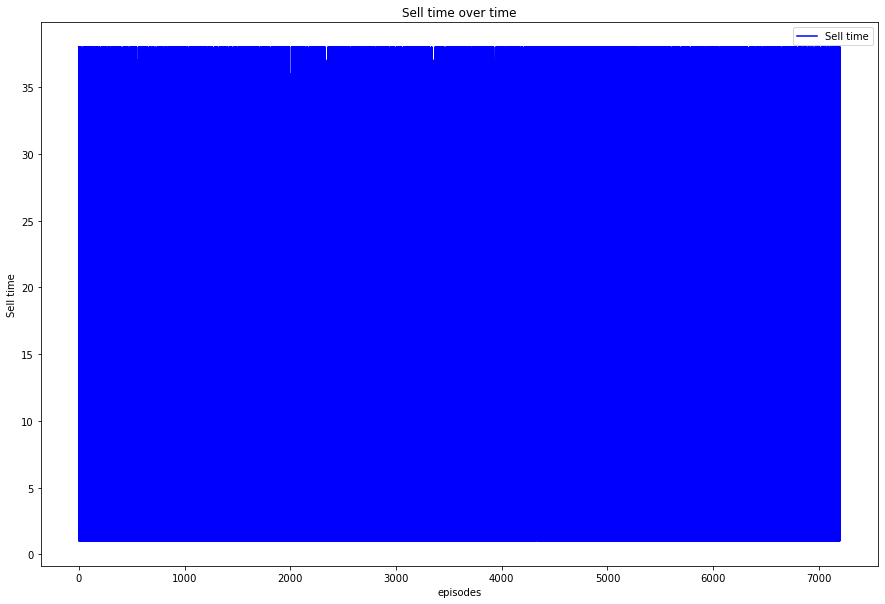

In [74]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Second Valid

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 635
num_episodes_per_epoch: 40680
min value of stock: 86.93250253703438, max value of stock: 167.18632123196707


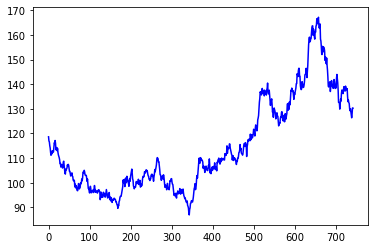

In [75]:
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(train_data)) + ', max value of stock: '+str(max(train_data)))
plt.plot(range(len(train_data)), train_data, color='b')

In [76]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:1'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                else:
                    a = a[0]
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Number of short selling: " + str(num_short_sell))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Loading Model...
INFO:tensorflow:Restoring parameters from /misc/scratch05/patx/fathanab/Experiments_RL/normalizeFirstDay_seed_corrected_2019_11_21_shuffled_GBM_version/savedModel/C51_noSoft_arch0-option_T50-history_t15-num_episodes203400-softUpdateFalse-tau0.001-dropout0.19999999999999996True-num_layers3-freq30-batch64-capacity3000-lambda0.0025-final
episode 100: 	0.02761065262272114	18.18
episode 200: 	0.032254331426177923	19.02
episode 300: 	0.026119177028530758	15.95
episode 400: 	0.03242576097116217	17.81
episode 500: 	0.025152960804595625	17.04
episode 600: 	0.03284127559812509	19.84
episode 700: 	0.026053020432484413	16.81
episode 800: 	0.02765602709753905	18.23
episode 900: 	0.031997820496430684	18.12
episode 1000: 	0.03448767131876346	18.56
episode 1100: 	0.02544038445391662	16.28
episode 1200: 	0.027524134385884646	17.29
episode 1300: 	0.031078259671477353	18.31
episode 1400: 	0.02743672680862708	16.81
episode 1500: 	0.03228775044611423	17.93
episode 1600: 	0.0213625542276919

In [77]:
# Normal Test
# 4000 episodes
#Average reward per episode: -0.0004459820152409164%
#Time to execute: 1.0273285110791524min

# 10000 episodes of training (23000 episodes)
#Average reward per episode: -0.0006903839079534307%
#Time to execute: 18.210397080580393min

# 30000 episodes of training (23000 episodes)
#Average reward per episode: -0.0015529333479744412%
#Time to execute: 27.645483565330505min

# 20000 episodes of training
#Average reward per episode: -0.0049713977980137885%
#Time to execute: 31.664522131284077min

# 100000 episodes of training # architecture 0
#Total average reward per episode: -0.0031459276190924593
#Time to execute: 27.598839151859284min

#20000 episodes training
#Total average reward per episode: 0.0024760915583103395
#Time to execute: 2.219494903087616min

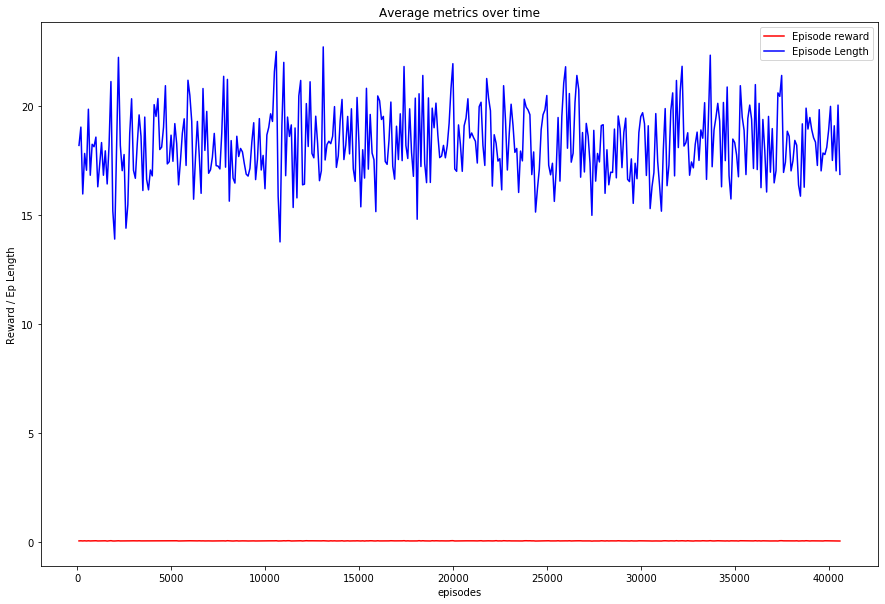

In [78]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

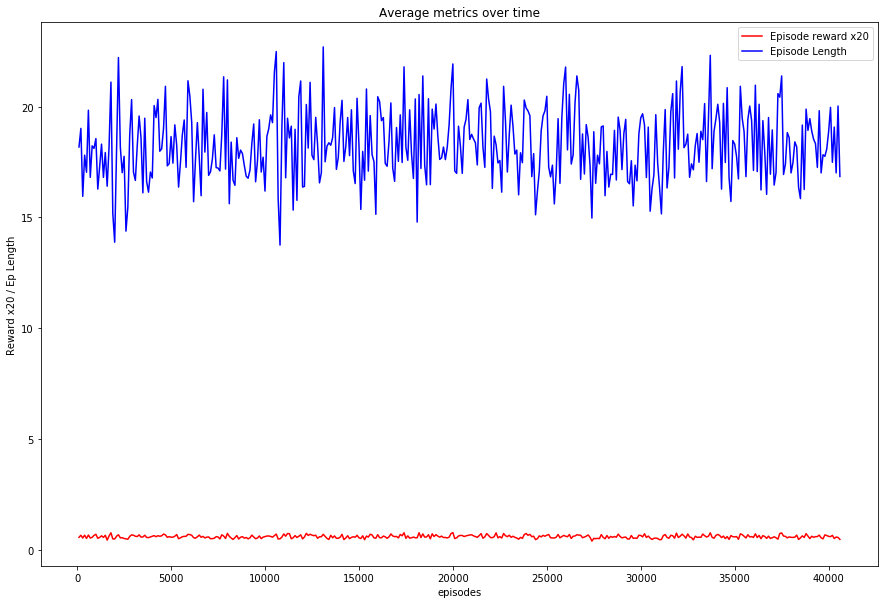

In [79]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

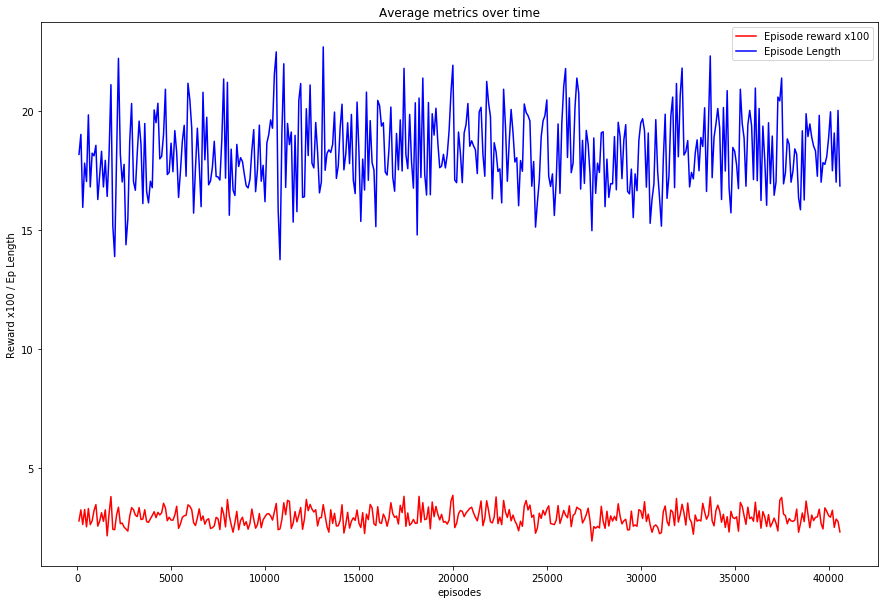

In [80]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

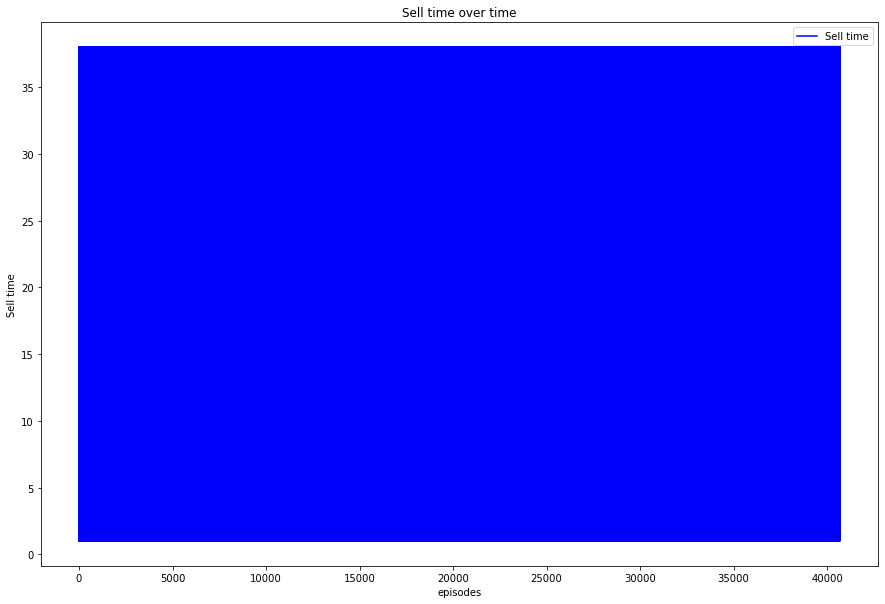

In [81]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Print size of remaining objects

In [82]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
#sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
list_objects = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
#print(list_objects)
for x,y in list_objects:
    print(str(x)+": "+str(y))
    del x

eList: 1671800
sTimeListMA: 1627296
state_train: 1573008
NonRandom_option_percentage_rList: 1320856
NonRandom_option_real_percentage_rList: 1320856
NonRandom_percentage_rList: 1320856
NonRandom_real_percentage_rList: 1320856
NonRandomrList: 1320856
NonRandomsTimeList: 1320856
m_prob: 992368
jList: 361296
maxPossibleOptionP_returnList: 361296
maxPossibleOptionR_P_returnList: 361296
maxPossibleP_returnList: 361296
maxPossibleR_P_returnList: 361296
maxPossiblerList: 361296
option_percentage_rList: 361296
option_real_percentage_rList: 361296
percentage_rList: 361296
rList: 361296
real_percentage_rList: 361296
sTimeList: 361296
AvgLossList: 16568
AvgNonRandomrList: 16568
AvgNonRandomsTimeList: 16568
AvgrListMA: 16368
AvgsTimeListMA: 16368
AvgNonRandomrListMA: 16128
AvgNonRandomsTimeListMA: 16128
stock_data: 7992
real_train_data: 6040
train_data: 6040
AvgEpisodeList: 3768
AvgrList: 3768
AvgsTimeList: 3768
Qnetwork: 2008
real_test_data: 1576
test_data: 1576
AmericanOptionPricing: 1064
GBM: 10